<a href="https://colab.research.google.com/github/FabrizioBoncoraglio/Machine-Learning-Project/blob/main/Computational_Science_Project_Fabrizio_Boncoraglio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import packages
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import umap.umap_ as umap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.mixture import GaussianMixture
from collections import defaultdict



In [ ]:
%pip install umap
%pip install umap-learn
%pip install scipy


  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3543 sha256=5330fd9336577730c43ee6e263649188dd734744ef6952a8cad0167a2acc2356
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.0 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=527d35deea8db6de31095ef5fcb3edcb953bcc0a259d4280942ac69146597361
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


# One-Hot Encoding

Task 1: One-hot encoding of protein sequence data.
Categorical variables are frequently represented in one-hot encoding, i.e. as vectors containing one entry equal to 1, and all the other equal to 0. In the case of protein data, a little variant is useful: containing one entry equal to 1, and all the other equal to 0. In the case of protein data, a little variant in useful: you may use a 20-dimensional representation with A->(1,...,0),C->(0,1,...,0),...,Y->(0,...,0,1), while the gap is mapped to the zero vector, - ->(0,...,0). Note that the one-hot encoding blows up the feature vectors from L=96 categorical variables (the lenght of each protein sequence) to 20L=1920 binary variables, but the numerical treatment is easies.

In [ ]:
def parse_fasta_file(filepath):
    # Define the amino acids and the mapping to one-hot vectors
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_to_onehot = {aa: [1 if aa == a else 0 for a in amino_acids] for aa in amino_acids} #put a 1 in the position of the amino acid read in the file and 19 zeros
    aa_to_onehot['-'] = [0] * 20  # the alignment gap is represented by a 20-zero component vector

    onehot_sequences = []
    labels = []

    with open(filepath, 'r') as file:
        while True:
            header = file.readline().strip()
            if not header:
                break

            # Read the two lines of the sequence and concatenate them because of the structure of the file
            sequence = file.readline().strip() + file.readline().strip()
            file.readline()  # Skip the empty line

            # Extract the label from the header True or False
            label = 1 if header[-4:] == 'true' else 0
            labels.append(label)

            # One-hot encode the sequence
            onehot_seq = []
            for aa in sequence:
                onehot_seq.extend(aa_to_onehot.get(aa, [0] * 20))

            onehot_sequences.append(onehot_seq)

    return np.array(onehot_sequences), np.array(labels)

# File paths that has to be changed
nat_filepath = '/content/MSA_nat_with_annotation.faa'
art_filepath = '/content/MSA_art.faa'

#natural sequences
onehot_nat, labels_nat = parse_fasta_file(nat_filepath)

# artificial sequences
onehot_art, labels_art = parse_fasta_file(art_filepath)



In [ ]:
# Checking the dimensions of the output arrays for the artificial sequences and it's correct
onehot_art.shape, labels_art.shape

((1003, 1920), (1003,))

In [ ]:
# Checking the dimensions of the output arrays for the artificial sequences and it's correct
onehot_nat.shape, labels_nat.shape

((1130, 1920), (1130,))

In [ ]:
# Now, let's calculate the number of functioning and not functioning proteins in both datasets as well as the fraction of functioning proteins.

def analyze_functionality(labels):
    total = len(labels)
    functioning = sum(labels)
    not_functioning = total - functioning
    fraction_functioning = functioning / total *100
    return functioning, not_functioning, fraction_functioning

functioning_nat, not_functioning_nat, fraction_nat = analyze_functionality(labels_nat)
functioning_art, not_functioning_art, fraction_art = analyze_functionality(labels_art)

functioning_nat, not_functioning_nat, fraction_nat, functioning_art, not_functioning_art, fraction_art

print(f"Number of functioning proteins in the natural dataset={functioning_nat}\nNumber of not-functioning proteins in the natural dataset={not_functioning_nat}")
print(f"Fraction of functioning proteins in the natural dataset={fraction_nat}%")
print(f"Number of functioning proteins in the artificial dataset={functioning_art}\nNumber of not-functioning proteins in the artificial dataset={not_functioning_art}")
print(f"Fraction of functioning proteins in the artificial dataset={fraction_art}%")

Number of functioning proteins in the natural dataset=423
Number of not-functioning proteins in the natural dataset=707
Fraction of functioning proteins in the natural dataset=37.43362831858407%
Number of functioning proteins in the artificial dataset=499
Number of not-functioning proteins in the artificial dataset=504
Fraction of functioning proteins in the artificial dataset=49.750747756729815%


# Data Visualization

Task 2: Dimensional reduction and visualization of sequence space
Use PCA of the natural data in one-hot encoding, to determine the frst few principle components (PCs) of the
dataset. Project sequences onto PCs and represent graphically the dimensionally reduced data. What do you observe?
Color sequences according to their functionality. Are functional and non-functional sequences well sperarated in
PCA space? Project also the generated sequences onto the PCs determined from the natural data. Do they occupy
a similar region in (dimensionally reduced) sequence space?


In [ ]:
# Applying PCA with 3 components to capture more variance
pca_3d = PCA(n_components=3)
pca_3d_nat = pca_3d.fit_transform(onehot_nat)

# Extract the percentage of variance explained by the first 3 components
explained_variance_3d = pca_3d.explained_variance_ratio_

# Applying PCA with 2 components for 2D visualization
pca_2d = PCA(n_components=2)
pca_2d_nat = pca_2d.fit_transform(onehot_nat)

explained_variance_2d = pca_2d.explained_variance_ratio_

print(f"Explained Variance by Each Component (3D PCA): {explained_variance_3d}")
print(f"Total Variance Explained (3D PCA): {sum(explained_variance_3d) * 100:.2f}%")
print(f"Explained Variance by Each Component (2D PCA): {explained_variance_2d}")
print(f"Total Variance Explained (2D PCA): {sum(explained_variance_2d) * 100:.2f}%")




Explained Variance by Each Component (3D PCA): [0.04337461 0.03301329 0.02579184]
Total Variance Explained (3D PCA): 10.22%
Explained Variance by Each Component (2D PCA): [0.04337461 0.03301329]
Total Variance Explained (2D PCA): 7.64%


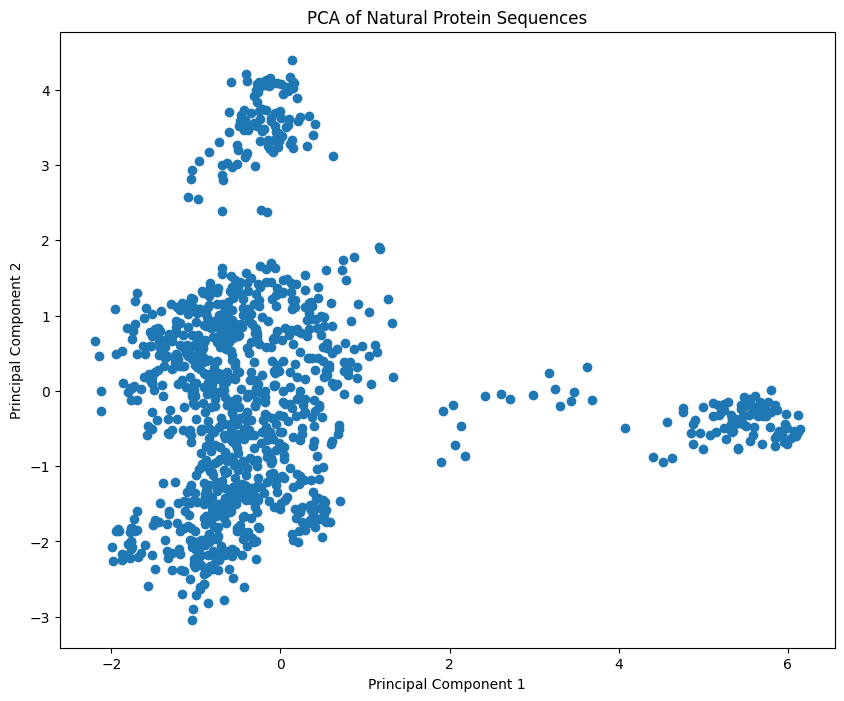

In [ ]:

# plot of the projection of the natural sequences on the first 2 principal components. Keep in mind that PCA is a linear method.
plt.figure(figsize=(10, 8))
plt.scatter(pca_2d_nat[:, 0], pca_2d_nat[:, 1])
plt.title('PCA of Natural Protein Sequences')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


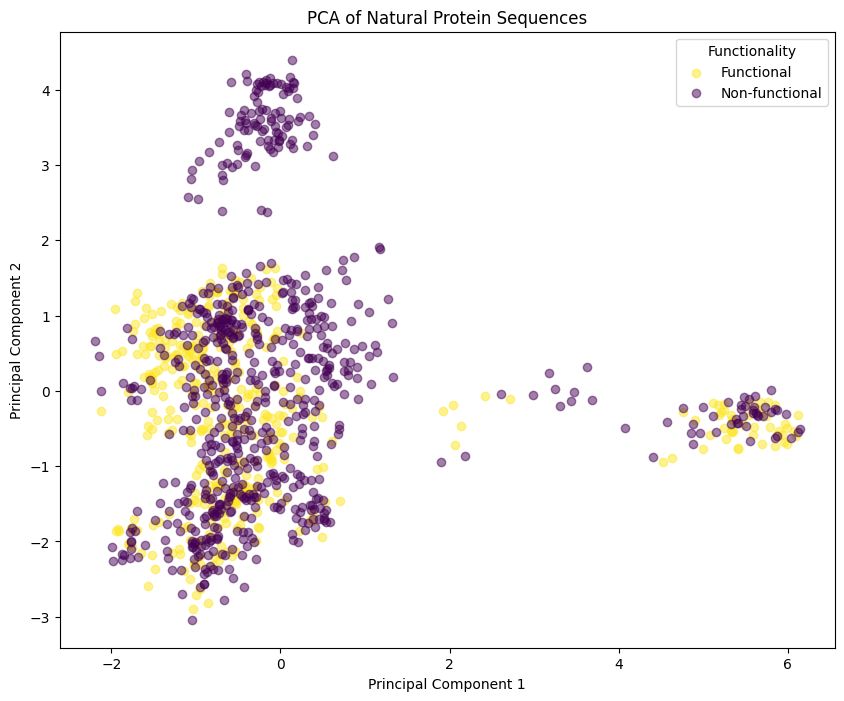

In [ ]:
#color differently functional proteins and non-functional ones
cmap = plt.cm.viridis
color_non_functional = cmap(0.0)  # Color for functionality 0
color_functional = cmap(0.999)  # Color for functionality 1

# Separating the PCA-transformed data by functionality
functional_indices = labels_nat == 1
non_functional_indices = labels_nat == 0

plt.figure(figsize=(10, 8))
plt.scatter(pca_2d_nat[functional_indices, 0], pca_2d_nat[functional_indices, 1], color=color_functional, alpha=0.5, label='Functional')
plt.scatter(pca_2d_nat[non_functional_indices, 0], pca_2d_nat[non_functional_indices, 1], color=color_non_functional, alpha=0.5, label='Non-functional')
plt.title('PCA of Natural Protein Sequences')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Functionality')
plt.show()


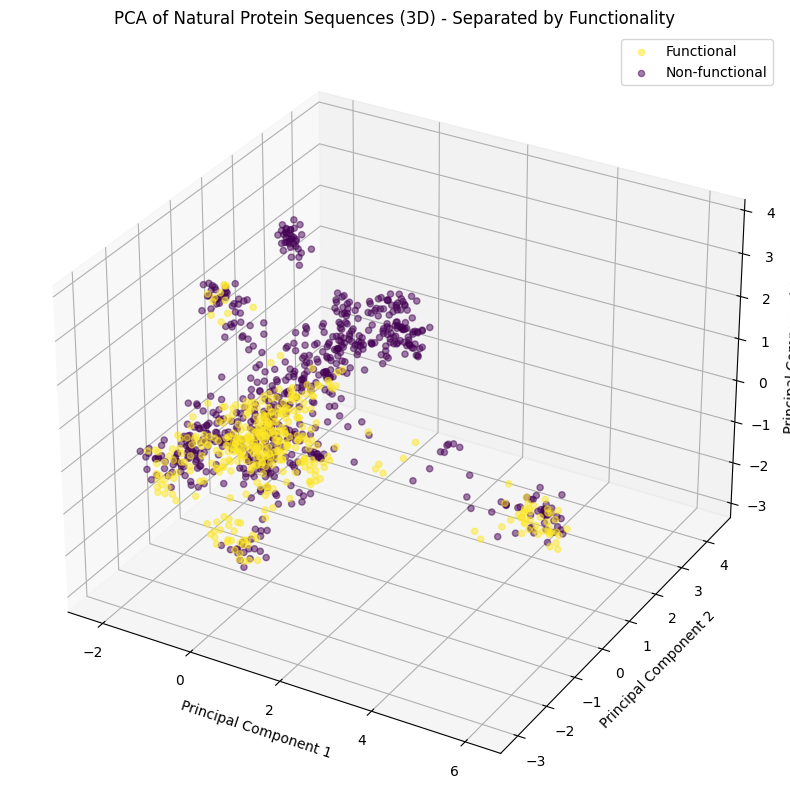

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_3d_nat[functional_indices, 0], pca_3d_nat[functional_indices, 1], pca_3d_nat[functional_indices, 2], color=color_functional, alpha=0.5, label='Functional')
ax.scatter(pca_3d_nat[non_functional_indices, 0], pca_3d_nat[non_functional_indices, 1], pca_3d_nat[non_functional_indices, 2], color=color_non_functional, alpha=0.5, label='Non-functional')
ax.set_title('PCA of Natural Protein Sequences (3D) - Separated by Functionality')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

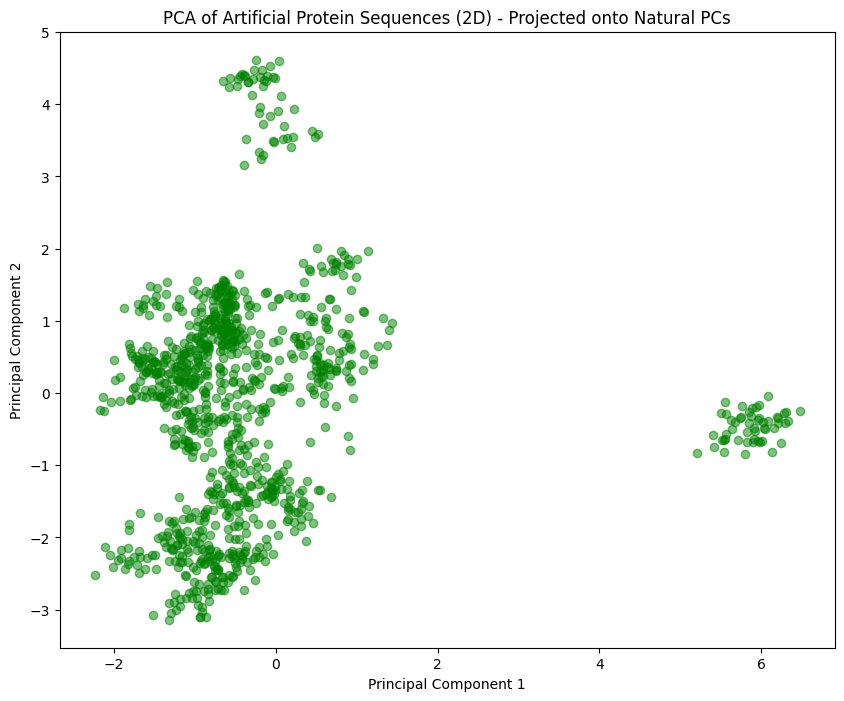

In [ ]:
#Now let's plot the artificial sequences in 2d onto the principal components of the natural ones.
pca_2d_art = pca_2d.transform(onehot_art)

plt.figure(figsize=(10, 8))
plt.scatter(pca_2d_art[:, 0], pca_2d_art[:, 1], color='green', alpha=0.5)
plt.title('PCA of Artificial Protein Sequences (2D) - Projected onto Natural PCs')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


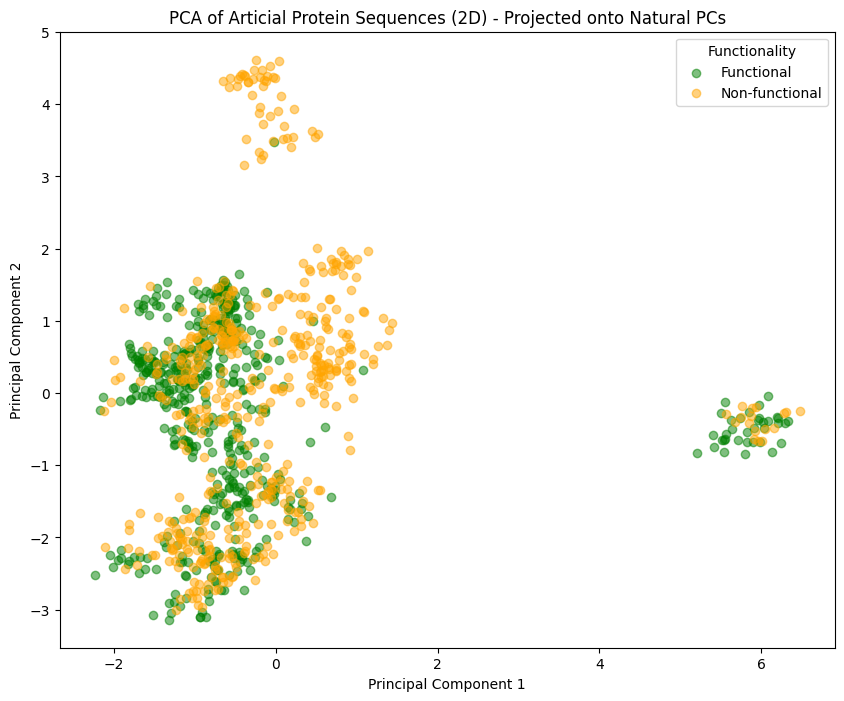

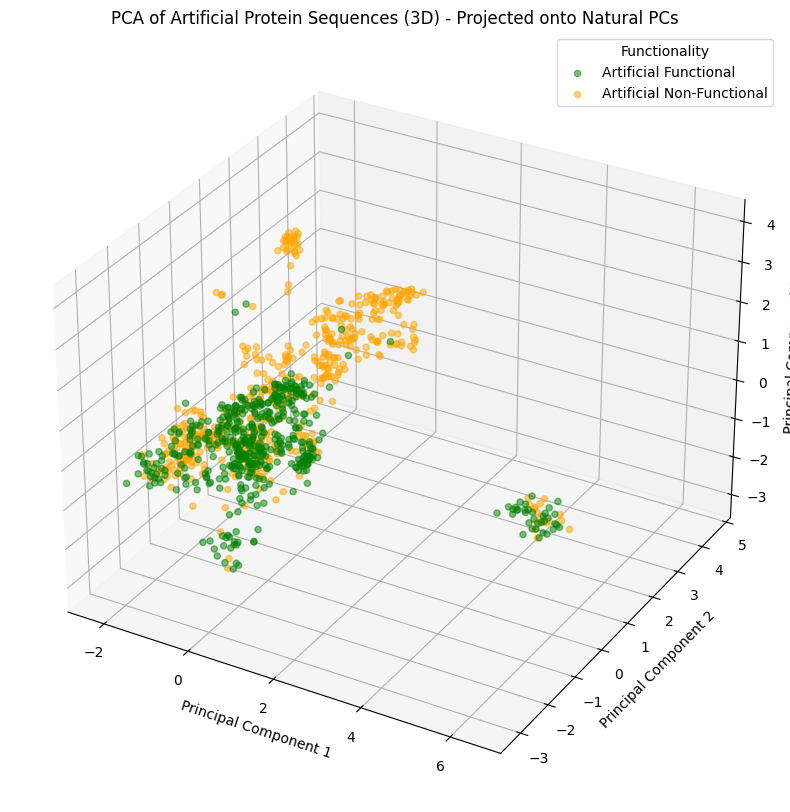

In [ ]:
# Separating the PCA-transformed data (artificial onto the principal components of the natural) by functionality
pca_2d_art = pca_2d.transform(onehot_art)
pca_3d_art = pca_3d.transform(onehot_art)


functional_indices_art = labels_art == 1
non_functional_indices_art = labels_art == 0

plt.figure(figsize=(10, 8))
plt.scatter(pca_2d_art[functional_indices_art, 0], pca_2d_art[functional_indices_art, 1], color='green', alpha=0.5, label='Functional')
plt.scatter(pca_2d_art[non_functional_indices_art, 0], pca_2d_art[non_functional_indices_art, 1], color='orange', alpha=0.5, label='Non-functional')
plt.title('PCA of Articial Protein Sequences (2D) - Projected onto Natural PCs')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Functionality')
plt.show()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_3d_art[functional_indices_art, 0], pca_3d_art[functional_indices_art, 1], pca_3d_art[functional_indices_art, 2], color='green', alpha=0.5,label='Artificial Functional')
ax.scatter(pca_3d_art[non_functional_indices_art, 0], pca_3d_art[non_functional_indices_art, 1], pca_3d_art[non_functional_indices_art, 2], color='orange', alpha=0.5,label='Artificial Non-Functional')
ax.set_title('PCA of Artificial Protein Sequences (3D) - Projected onto Natural PCs')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend(title='Functionality')
plt.show()



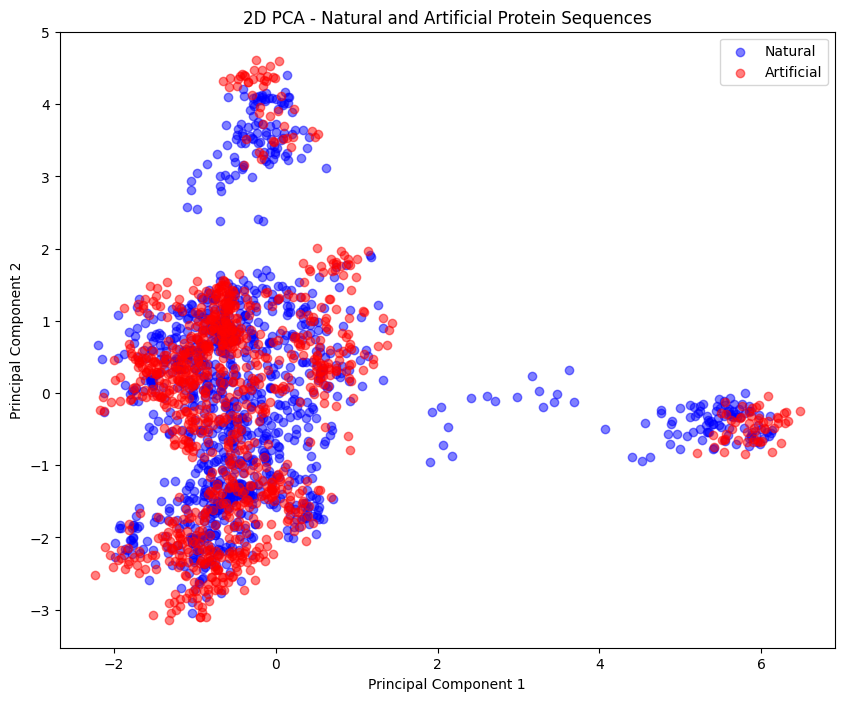

In [ ]:
#Let's put everything togheter, both natural and artificial
plt.figure(figsize=(10, 8))

# Natural Sequences
plt.scatter(pca_2d_nat[:, 0], pca_2d_nat[:, 1], color='blue', alpha=0.5, label='Natural')

# Artificial Sequences
plt.scatter(pca_2d_art[:, 0], pca_2d_art[:, 1], color='red', alpha=0.5, label='Artificial')

plt.title('2D PCA - Natural and Artificial Protein Sequences')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()



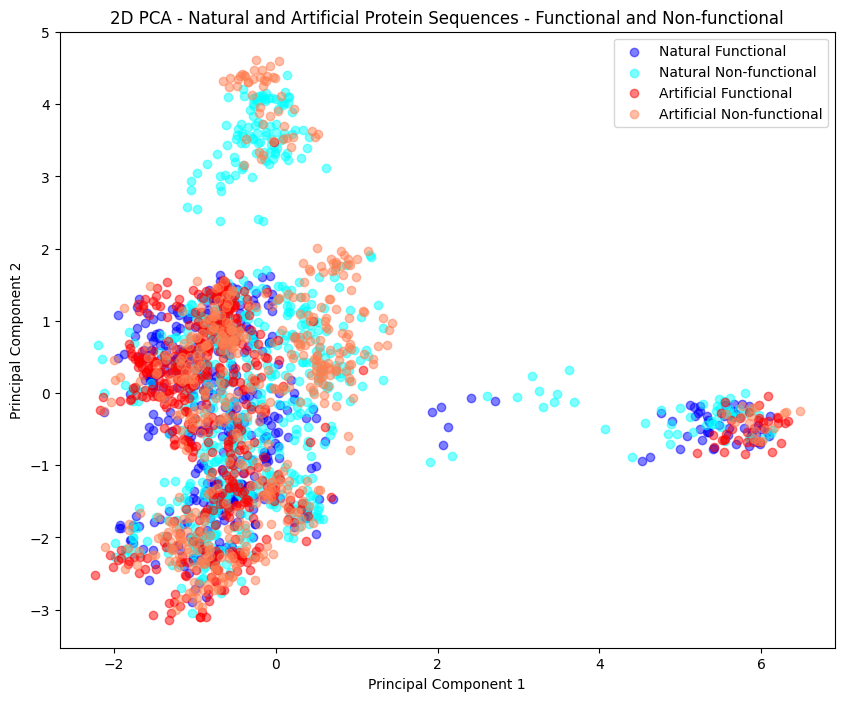

In [ ]:
plt.figure(figsize=(10, 8))

# Natural Sequences colored differently according to their functionality
plt.scatter(pca_2d_nat[labels_nat == 1, 0], pca_2d_nat[labels_nat == 1, 1], color='blue', alpha=0.5, label='Natural Functional')
plt.scatter(pca_2d_nat[labels_nat == 0, 0], pca_2d_nat[labels_nat == 0, 1], color='cyan', alpha=0.5, label='Natural Non-functional')

# Artificial Sequences colored differently according to their functionality
plt.scatter(pca_2d_art[labels_art == 1, 0], pca_2d_art[labels_art == 1, 1], color='red', alpha=0.5, label='Artificial Functional')
plt.scatter(pca_2d_art[labels_art == 0, 0], pca_2d_art[labels_art == 0, 1], color='coral', alpha=0.5, label='Artificial Non-functional')

plt.title('2D PCA - Natural and Artificial Protein Sequences - Functional and Non-functional')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

Explained Variance by Each Component (3D PCA): [0.04337461 0.03301329 0.02579184]
Total Variance Explained (3D PCA): 10.22%
Explained Variance by Each Component (2D PCA): [0.04337461 0.03301329]
Total Variance Explained (2D PCA): 7.64%


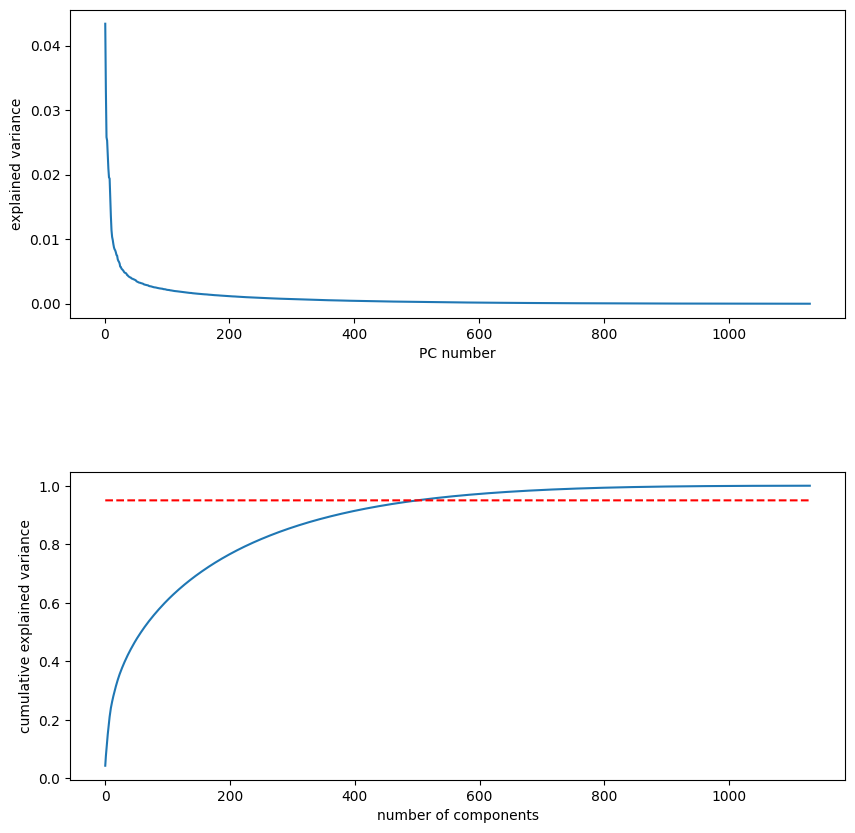

In [ ]:
#How well is PCA? Let's print again the explained variance of the first 3 and 2 components for the natural sequences pca
print(f"Explained Variance by Each Component (3D PCA): {explained_variance_3d}")
print(f"Total Variance Explained (3D PCA): {sum(explained_variance_3d) * 100:.2f}%")
print(f"Explained Variance by Each Component (2D PCA): {explained_variance_2d}")
print(f"Total Variance Explained (2D PCA): {sum(explained_variance_2d) * 100:.2f}%")

pca = PCA().fit(onehot_nat)
variances = pca.explained_variance_ratio_

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# line plot for explained variances
axes[0].plot(range(1, len(variances) + 1), variances)
axes[0].set_xlabel('PC number')
axes[0].set_ylabel('explained variance')

# Set threshold for cumulative explained variance.
#The intersection between the cumulative curve and the dashed line gives the  umber of components needed to explain the 95% of the variance.
threshold = 0.95
t = np.ones(1130) * threshold

# Cumulative sum of the principal component information content
axes[1].plot(np.cumsum(pca.explained_variance_ratio_))
axes[1].plot(np.arange(1130), t, linestyle='--', color='red')  # Adding a dashed line for the threshold
axes[1].set_xlabel('number of components')
axes[1].set_ylabel('cumulative explained variance')

# Adjust subplots spacing
plt.subplots_adjust(hspace=0.5)
plt.show()


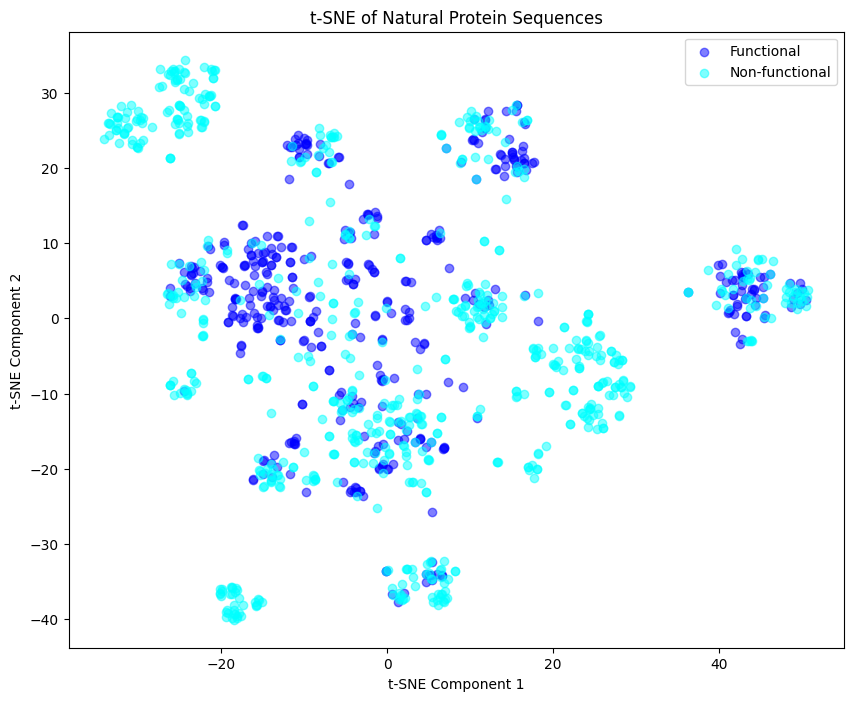

In [ ]:
# Applying t-SNE to the natural sequences, nonlinear method. I tried different perplexities.
tsne = TSNE(n_components=2,perplexity=50, random_state=50)
tsne_nat = tsne.fit_transform(onehot_nat)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_nat[labels_nat == 1, 0], tsne_nat[labels_nat == 1, 1], color='blue', alpha=0.5, label='Functional')
plt.scatter(tsne_nat[labels_nat == 0, 0], tsne_nat[labels_nat == 0, 1], color='cyan', alpha=0.5, label='Non-functional')
plt.title('t-SNE of Natural Protein Sequences')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()



/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<ipython-input-153-8dcdfe3542b1>:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(umap_2d_nat[indices, 0], umap_2d_nat[indices, 1], c=color, label=label, alpha=0.5)


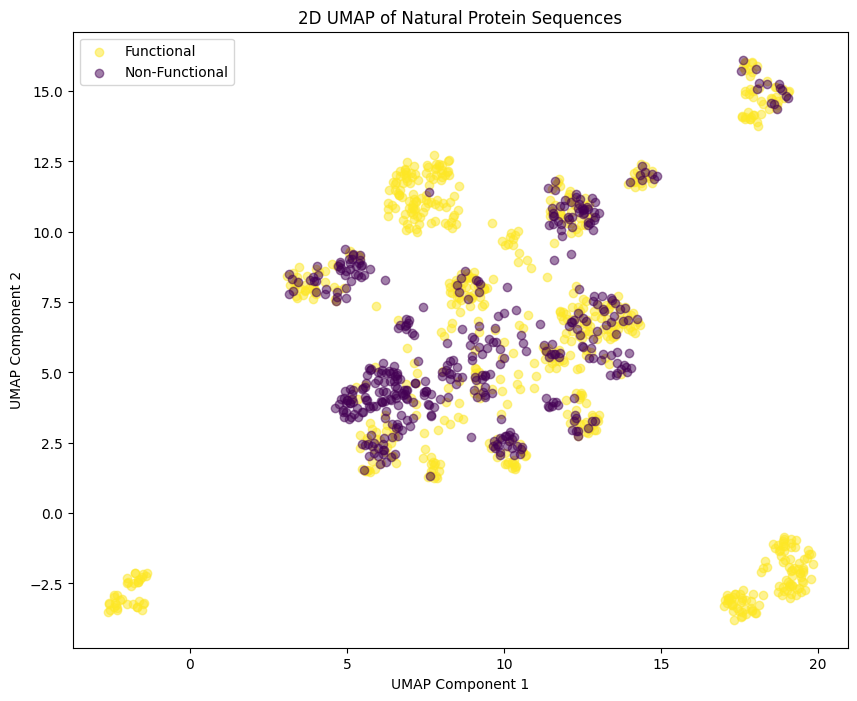

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<ipython-input-153-8dcdfe3542b1>:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(umap_3d_nat[indices, 0], umap_3d_nat[indices, 1], umap_3d_nat[indices, 2], c=color, label=label, alpha=0.5)


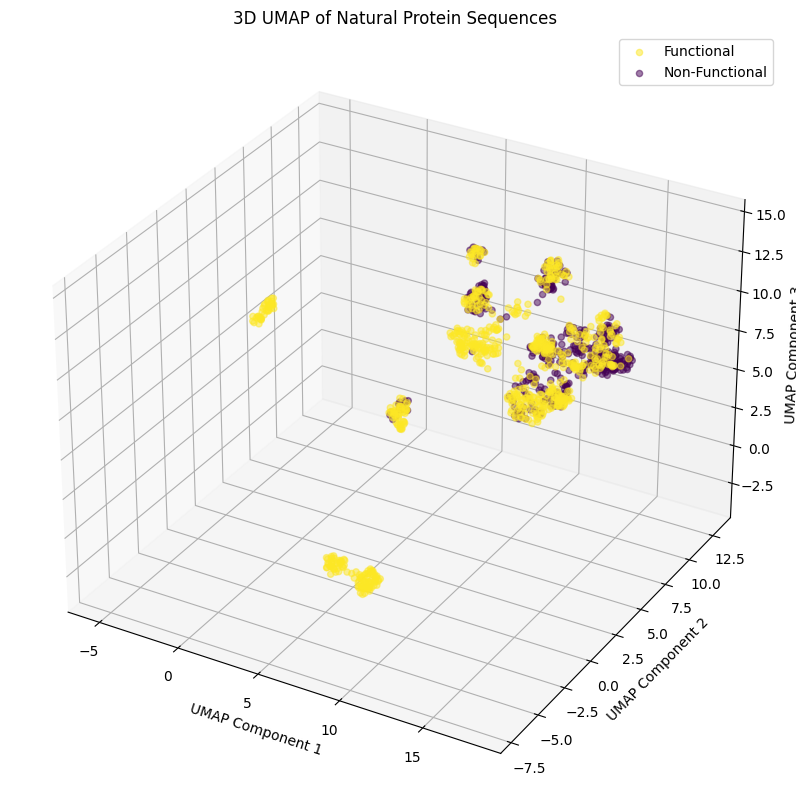

In [ ]:
#Let's apply UMAP (Uniform Manifold Approximation and Projection) on natural sequences. I use cosine distance as a metric. Remember that cosine distance = 1 - cosine similarity
#UMAP is generally faster than t-SNE, especially on larger datasets and can be applied to a wide variety of data types, like text.
umap_2d = umap.UMAP(n_neighbors=50, min_dist=0.6, n_components=2, metric='cosine', random_state=50)
umap_2d_nat = umap_2d.fit_transform(onehot_nat)

cmap = plt.cm.viridis
color_non_functional = cmap(0.001)
color_functional = cmap(0.999)
colors = np.array([color_functional if label == 1 else color_non_functional for label in labels_nat])

# Plotting 2D UMAP of Natural Sequences and separate functionality
plt.figure(figsize=(10, 8))
for func_status, color, label in [(0, color_functional, 'Functional'), (1, color_non_functional, 'Non-Functional')]:
    indices = labels_nat == func_status
    plt.scatter(umap_2d_nat[indices, 0], umap_2d_nat[indices, 1], c=color, label=label, alpha=0.5)

plt.title('2D UMAP of Natural Protein Sequences')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

# UMAP in 3D
umap_3d = umap.UMAP(n_neighbors=50, min_dist=0.6, n_components=3, metric='cosine', random_state=50)
umap_3d_nat = umap_3d.fit_transform(onehot_nat)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
for func_status, color, label in [(0, color_functional, 'Functional'), (1, color_non_functional, 'Non-Functional')]:
    indices = labels_nat == func_status
    ax.scatter(umap_3d_nat[indices, 0], umap_3d_nat[indices, 1], umap_3d_nat[indices, 2], c=color, label=label, alpha=0.5)

ax.set_title('3D UMAP of Natural Protein Sequences')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
ax.legend()
plt.show()

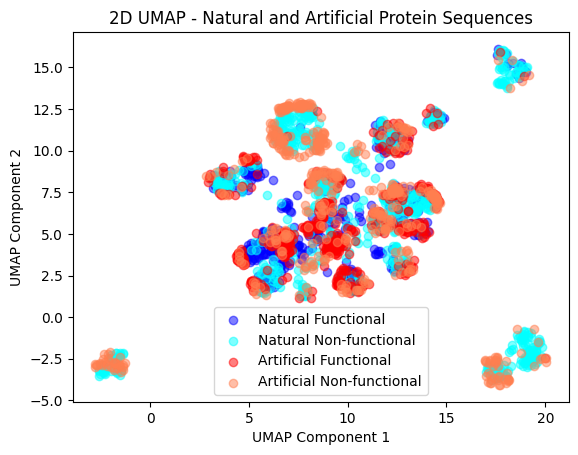

In [ ]:
#project the artificial sequences onto the 2 umap components of the natural ones.
umap_2d_art = umap_2d.transform(onehot_art)

plt.scatter(umap_2d_nat[labels_nat == 1, 0], umap_2d_nat[labels_nat == 1, 1], color='blue', alpha=0.5, label='Natural Functional')
plt.scatter(umap_2d_nat[labels_nat == 0, 0], umap_2d_nat[labels_nat == 0, 1], color='cyan', alpha=0.5, label='Natural Non-functional')
plt.scatter(umap_2d_art[labels_art == 1, 0], umap_2d_art[labels_art == 1, 1], color='red', alpha=0.5, label='Artificial Functional')
plt.scatter(umap_2d_art[labels_art == 0, 0], umap_2d_art[labels_art == 0, 1], color='coral', alpha=0.5, label='Artificial Non-functional')

plt.title('2D UMAP - Natural and Artificial Protein Sequences')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()


# Clustering Techniques

Task 3: Clustering sequence data
Use a clustering algorithm of your choice (k-means, hierarchical...) to cluster the natural sequences, try diferent
cluster numbers. Represent clusters graphically using the PCA of Task 2. Discuss your observations. Are functional
and nonfunctional sequences separated into distinct clusters?
Unify natural and artifcial sequences into one large dataset, and apply again the clustering algorithm. Are the two
datasets separated by this procedure, or are clusters mixed in natural and artifcial sequences?


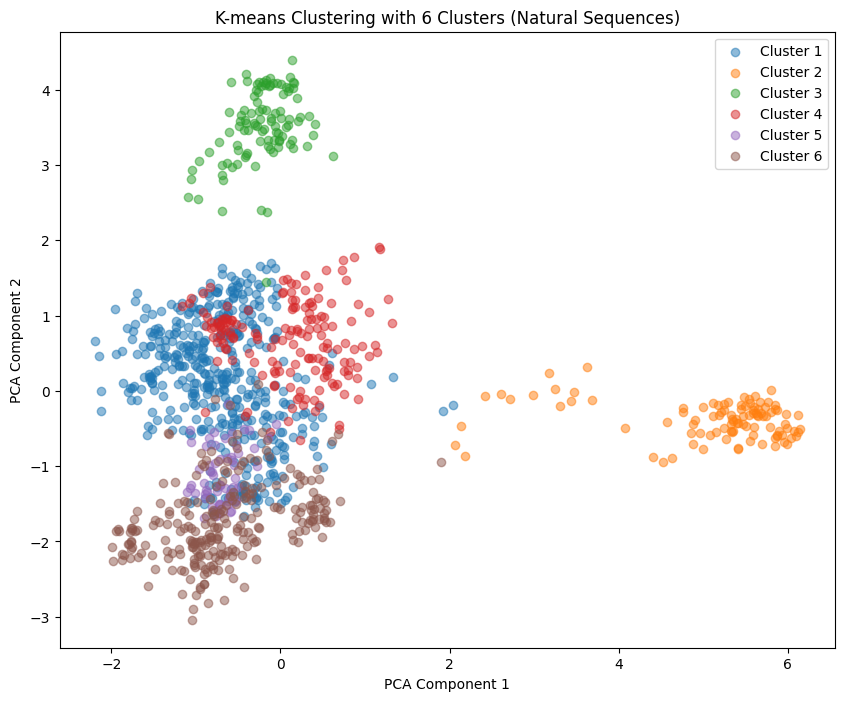

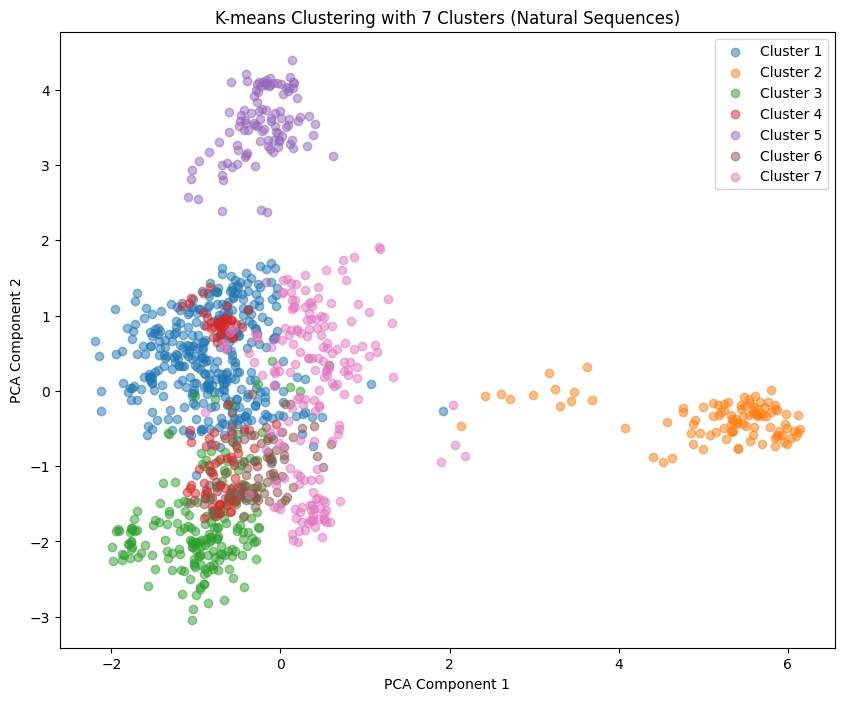

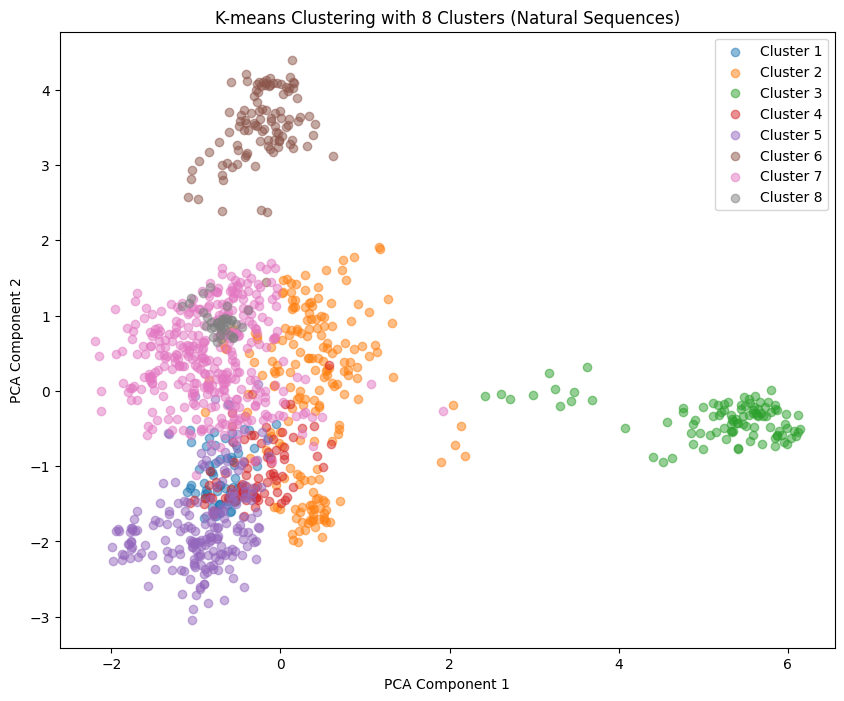

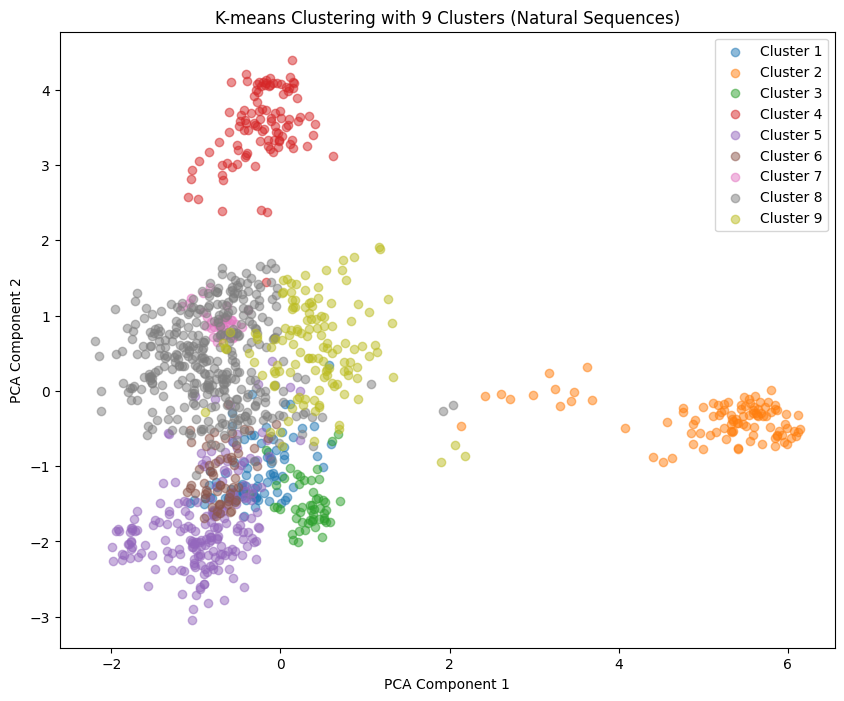

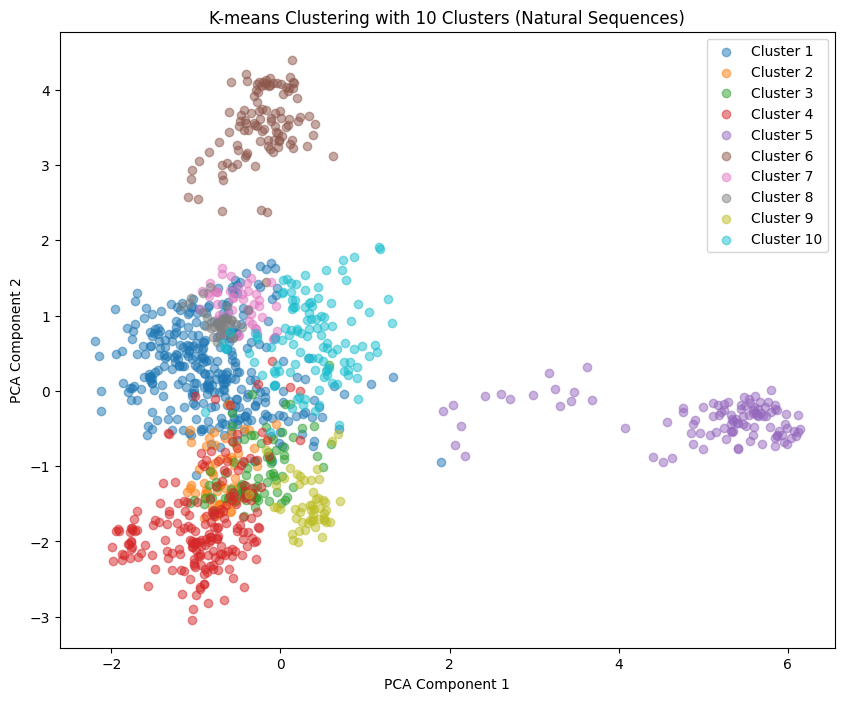

In [ ]:
# After many trials, I concentrate on this number of clusters.
num_clusters = [6, 7, 8, 9, 10]

# Apply k-means to the natural sequences.
for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    clusters = kmeans.fit_predict(onehot_nat)

    # Plotting the clusters using 2 principal components of the natural sequences.
    plt.figure(figsize=(10, 8))
    for cluster in range(k):
        cluster_indices = clusters == cluster
        plt.scatter(pca_2d_nat[cluster_indices, 0], pca_2d_nat[cluster_indices, 1], alpha=0.5, label=f'Cluster {cluster+1}')

    plt.title(f'K-means Clustering with {k} Clusters (Natural Sequences)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

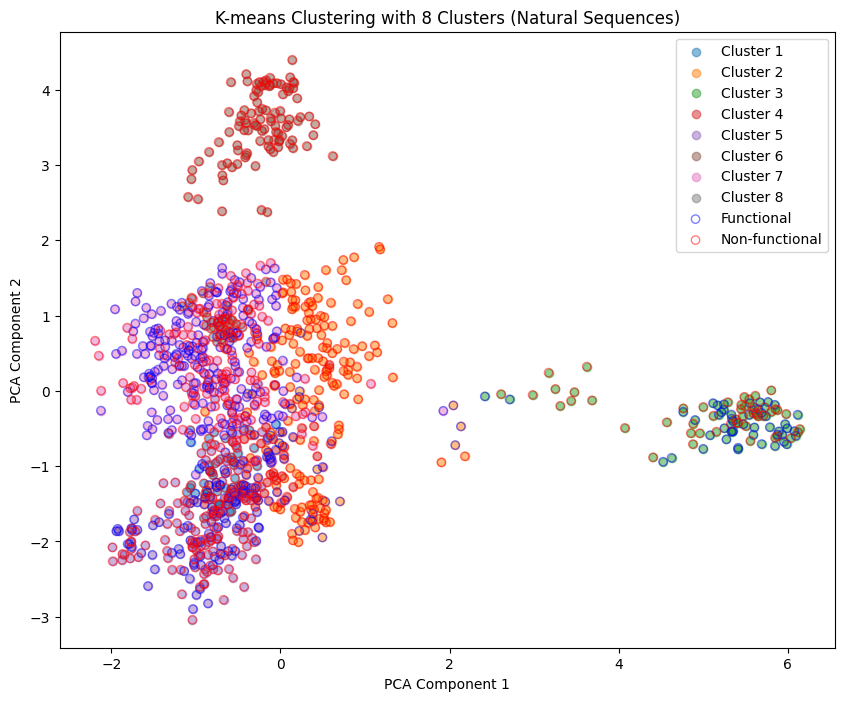

In [ ]:
# I take 8 clusters as an example and I color also the functionality of the proteins (the edge color gives the functionality, the color of the datapoints is the cluster)
num_clusters = [8]

# Apply k-means again.
for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    clusters = kmeans.fit_predict(onehot_nat)

    # Project again.
    plt.figure(figsize=(10, 8))
    for cluster in range(k):
        cluster_indices = clusters == cluster
        plt.scatter(pca_2d_nat[cluster_indices, 0], pca_2d_nat[cluster_indices, 1], alpha=0.5, label=f'Cluster {cluster+1}')

    # Coloring also the functionalities.
    plt.scatter(pca_2d_nat[labels_nat == 1, 0], pca_2d_nat[labels_nat == 1, 1], color='none', edgecolor='blue', alpha=0.5, label='Functional')
    plt.scatter(pca_2d_nat[labels_nat == 0, 0], pca_2d_nat[labels_nat == 0, 1], color='none', edgecolor='red', alpha=0.5, label='Non-functional')

    plt.title(f'K-means Clustering with {k} Clusters (Natural Sequences)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

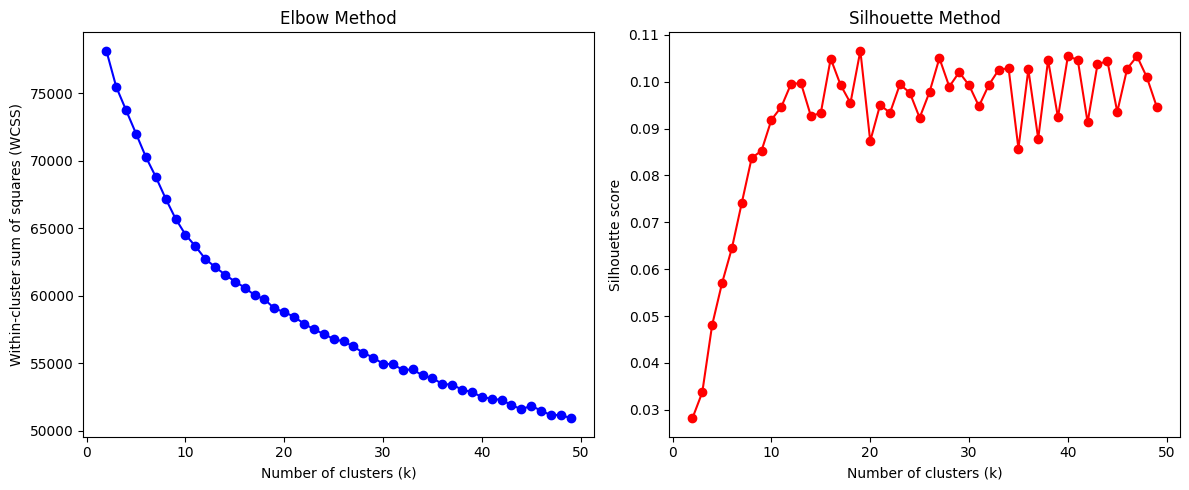

In [ ]:
#How to select the best number of clusters? I used 3 methods that proved to be more or less consistent with each other
#Scree plot, silhouette score and adjusted mutual information. All 3 have given an optimal number of clusters between 9 and 12 for the natural sequences.
k_values = range(2, 50)

elbow_method = []
silhouette_method = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    kmeans.fit(onehot_nat)

    #Scree plot: Within-cluster sum of squares (WCSS)
    elbow_method.append(kmeans.inertia_)

    # Silhouette score
    silhouette_avg = silhouette_score(onehot_nat, kmeans.labels_)
    silhouette_method.append(silhouette_avg)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, elbow_method, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_method, 'ro-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.tight_layout()
plt.show()
#For the elbow method, we look for a change of slope, while for the silhouette score we look for its maximum (before it loses in significativity).

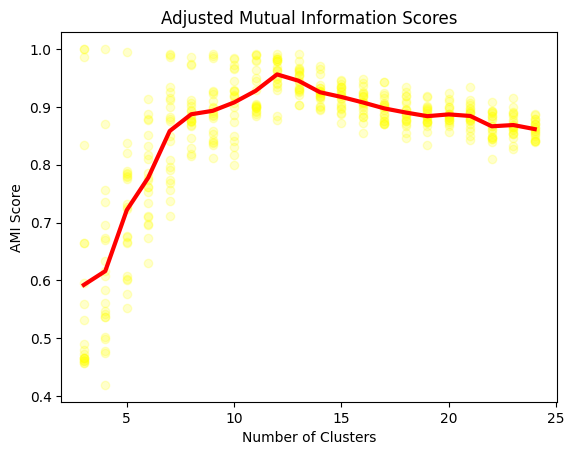

In [ ]:
#another important information-theoretical criterium to assess the optimal number of clusters is through the adjusted mutual information score.
#Adjusted Mutual Information (AMI) aims to understand if our clustering is persistent when we take different realisations of the noise.
#mutual information is generally higher for two clusterings with a larger number of clusters and in this senses it should be "adjusted".

clustmin = 3
clustmax = 25
amis_tot = []
iter = 7 #iterations for each number of clusters


for clust in range(clustmin,clustmax):
  amis = []
  for j in range(iter):
    c1 = KMeans(clust,init='k-means++',n_init = 20)
    c1.fit(onehot_nat)
    centers1 = c1.predict(onehot_nat)

    c2 = KMeans(clust,init='k-means++',n_init = 20)
    c2.fit(onehot_nat)
    centers2 = c2.predict(onehot_nat)

    c3 = KMeans(clust,init='k-means++',n_init = 20)
    c3.fit(onehot_nat)
    centers3 = c3.predict(onehot_nat)

    ami1 = adjusted_mutual_info_score(centers1,centers2)
    ami2 = adjusted_mutual_info_score(centers2,centers3)
    ami3 = adjusted_mutual_info_score(centers1,centers3)

    amis.append(ami1)
    amis.append(ami2)
    amis.append(ami3)
  amis_tot.append(amis)

for i in range(3*iter):
  plt.scatter(range(clustmin,clustmax),[amis_tot[j][i] for j in range(clustmax-clustmin)], c = 'yellow', alpha = 0.2)
plt.plot(range(clustmin,clustmax),[np.mean(amis_tot[i]) for i in range(clustmax-clustmin)], c = 'red', linewidth = 3)
plt.title('Adjusted Mutual Information Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('AMI Score')
plt.show()



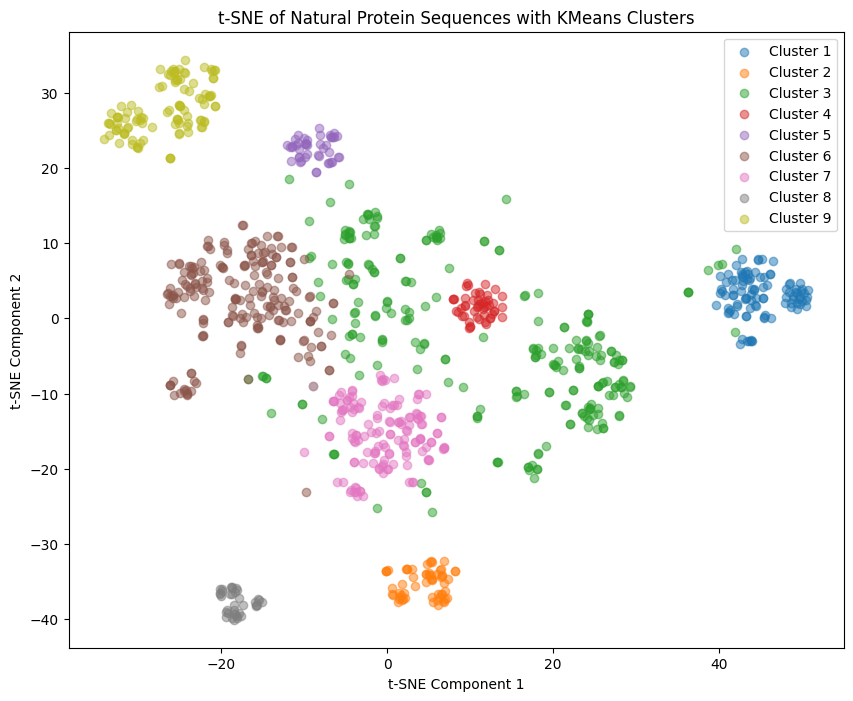

In [ ]:
#We already saw that when taking k=9 clusters and applying kmeans, the 2 principal components do not seem to separate clearly all clusters.
#Now we apply a 2 component tsne and project the natural sequences clustered onto the 2 tsne components
tsne = TSNE(n_components=2, perplexity=50, random_state=50)
tsne_nat = tsne.fit_transform(onehot_nat)

kmeans = KMeans(9, random_state=42, n_init=20)
clusters = kmeans.fit_predict(onehot_nat)

plt.figure(figsize=(10, 8))
for cluster in range(9):
    cluster_indices = np.where(clusters == cluster)
    plt.scatter(tsne_nat[cluster_indices, 0], tsne_nat[cluster_indices, 1], label=f'Cluster {cluster+1}', alpha=0.5)

plt.title('t-SNE of Natural Protein Sequences with KMeans Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()
#we see a much greater correspondance between sequences and clusters, apart from cluster number 3

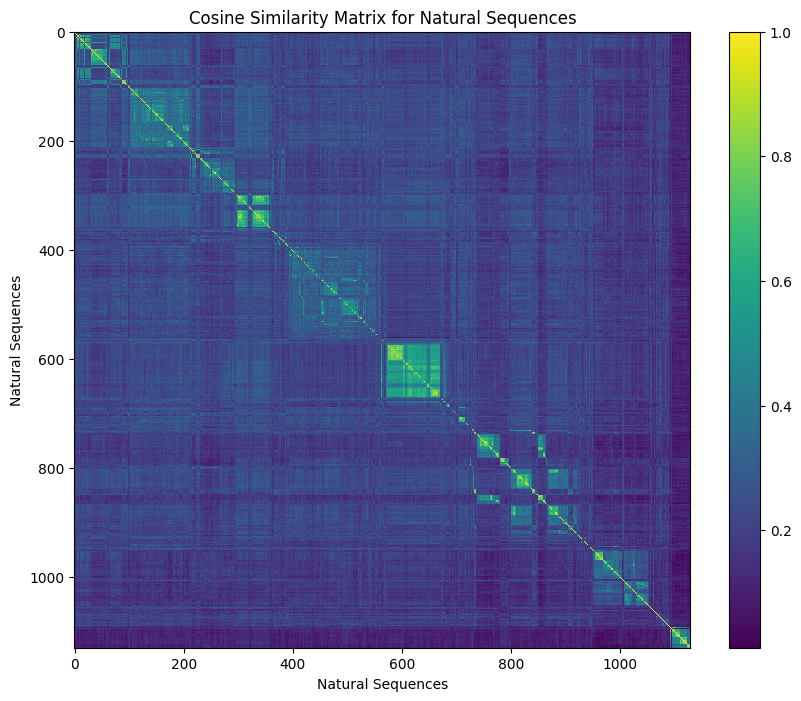

In [ ]:
# In this section we see how the cosine similarity matrix for natural sequences seems to underline some clustering in our sequences (the blocks of the matrix)
cos_sim_matrix_nat = cosine_similarity(onehot_nat, onehot_nat)

plt.figure(figsize=(10, 8))
plt.imshow(cos_sim_matrix_nat, cmap='viridis', interpolation='none')
plt.colorbar()
plt.title('Cosine Similarity Matrix for Natural Sequences')
plt.xlabel('Natural Sequences')
plt.ylabel('Natural Sequences')
plt.show()

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


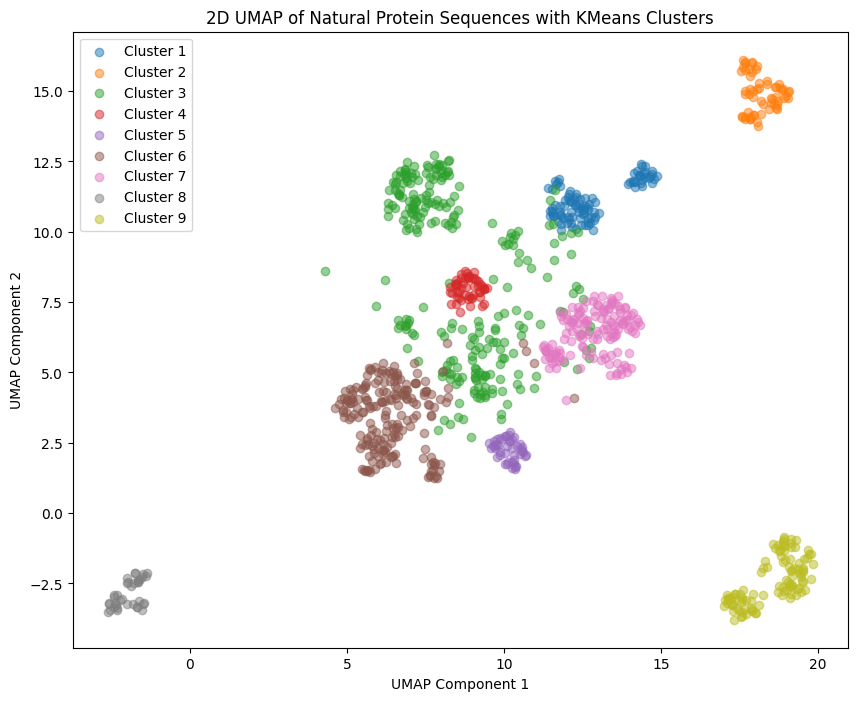

In [ ]:
#Following this hint, we project kmeans onto the 2 umap components with cosine distance, hoping to obtain better results.
kmeans = KMeans(9, random_state=42, n_init=20)
clusters = kmeans.fit_predict(onehot_nat)

# Here we project the clustered sequences onto the 2 UMAP components using the cosine distance following the insight of the similarity matrix (remembering that cos(distante)=1-cos(similarity)).
umap_2d = umap.UMAP(n_neighbors=50, min_dist=0.6, n_components=2, metric='cosine', random_state=50)
umap_2d_nat = umap_2d.fit_transform(onehot_nat)

plt.figure(figsize=(10, 8))
palette = np.array(plt.cm.tab10.colors[:9])

for cluster in range(9):
    idx = clusters == cluster
    plt.scatter(umap_2d_nat[idx, 0], umap_2d_nat[idx, 1], color=palette[cluster], label=f'Cluster {cluster+1}', alpha=0.5)

plt.title('2D UMAP of Natural Protein Sequences with KMeans Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()
#The clusters look more definite than t-sne. However, cluster number 3 has some problems.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 1:
  Total Proteins: 60
  Functional Proteins: 14
  Non-Functional Proteins: 46
  Functional/Total Ratio: 0.23

Cluster 2:
  Total Proteins: 150
  Functional Proteins: 24
  Non-Functional Proteins: 126
  Functional/Total Ratio: 0.16

Cluster 3:
  Total Proteins: 130
  Functional Proteins: 8
  Non-Functional Proteins: 122
  Functional/Total Ratio: 0.06

Cluster 4:
  Total Proteins: 318
  Functional Proteins: 200
  Non-Functional Proteins: 118
  Functional/Total Ratio: 0.63

Cluster 5:
  Total Proteins: 84
  Functional Proteins: 45
  Non-Functional Proteins: 39
  Functional/Total Ratio: 0.54

Cluster 6:
  Total Proteins: 196
  Functional Proteins: 72
  Non-Functional Proteins: 124
  Functional/Total Ratio: 0.37

Cluster 7:
  Total Proteins: 52
  Functional Proteins: 9
  Non-Functional Proteins: 43
  Functional/Total Ratio: 0.17

Cluster 8:
  Total Proteins: 103
  Functional Proteins: 51
  Non-Functional Proteins: 52
  Functional/Total Ratio: 0.50

Cluster 9:
  Total Proteins: 37


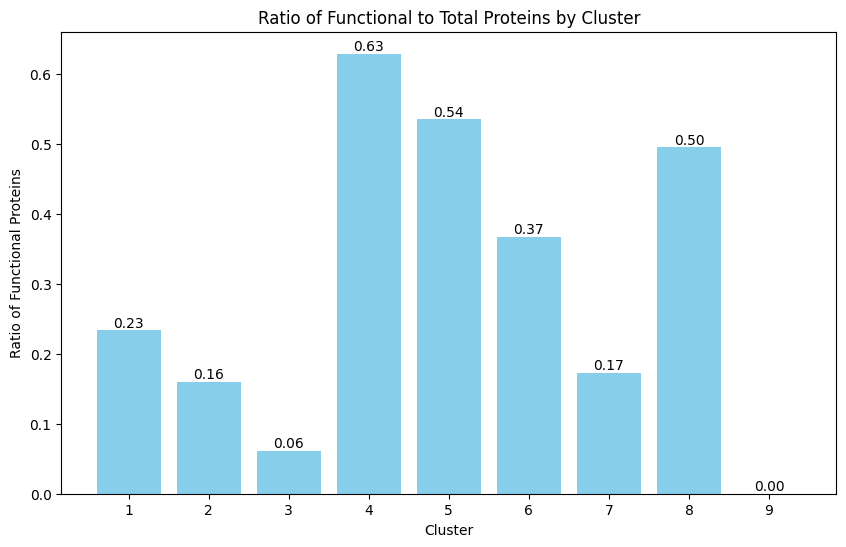

In [ ]:
#Now, let's analyse how functionality is split by the clustering procedure.
#I take k=9 and for wach cluster i plot the fraction of functional proteins and non-functional, as well as the ratio functional proteins in custer k/proteins in cluster k
kmeans = KMeans(n_clusters=9, random_state=4, n_init=20)
clusters = kmeans.fit_predict(onehot_nat)

cluster_info = []

for cluster in range(9):
    indices = clusters == cluster
    total_proteins = sum(indices)
    functional_proteins = sum(labels_nat[indices] == 1)
    non_functional_proteins = sum(labels_nat[indices] == 0)
    ratio_functional = functional_proteins / total_proteins if total_proteins > 0 else 0

    cluster_info.append((total_proteins, functional_proteins, non_functional_proteins, ratio_functional))

for idx, (total, func, non_func, ratio) in enumerate(cluster_info):
    print(f"Cluster {idx+1}:")
    print(f"  Total Proteins: {total}")
    print(f"  Functional Proteins: {func}")
    print(f"  Non-Functional Proteins: {non_func}")
    print(f"  Functional/Total Ratio: {ratio:.2f}")
    print()

ratios = [info[3] for info in cluster_info]

plt.figure(figsize=(10, 6))
plt.bar(range(1, 10), ratios, color='skyblue')

plt.xlabel('Cluster')
plt.ylabel('Ratio of Functional Proteins')
plt.title('Ratio of Functional to Total Proteins by Cluster (Natural Sequences)')
plt.xticks(range(1, 10))

for idx, ratio in enumerate(ratios):
    plt.text(idx + 1, ratio, f"{ratio:.2f}", ha='center', va='bottom')

plt.show()
#we see that cluster 9 contains only non-functional proteins.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 1 (Artificial):
  Total Proteins: 7
  Functional Proteins: 2
  Non-Functional Proteins: 5
  Functional/Total Ratio: 0.29

Cluster 2 (Artificial):
  Total Proteins: 106
  Functional Proteins: 45
  Non-Functional Proteins: 61
  Functional/Total Ratio: 0.42

Cluster 3 (Artificial):
  Total Proteins: 152
  Functional Proteins: 2
  Non-Functional Proteins: 150
  Functional/Total Ratio: 0.01

Cluster 4 (Artificial):
  Total Proteins: 329
  Functional Proteins: 253
  Non-Functional Proteins: 76
  Functional/Total Ratio: 0.77

Cluster 5 (Artificial):
  Total Proteins: 44
  Functional Proteins: 32
  Non-Functional Proteins: 12
  Functional/Total Ratio: 0.73

Cluster 6 (Artificial):
  Total Proteins: 222
  Functional Proteins: 110
  Non-Functional Proteins: 112
  Functional/Total Ratio: 0.50

Cluster 7 (Artificial):
  Total Proteins: 59
  Functional Proteins: 20
  Non-Functional Proteins: 39
  Functional/Total Ratio: 0.34

Cluster 8 (Artificial):
  Total Proteins: 52
  Functional Protein

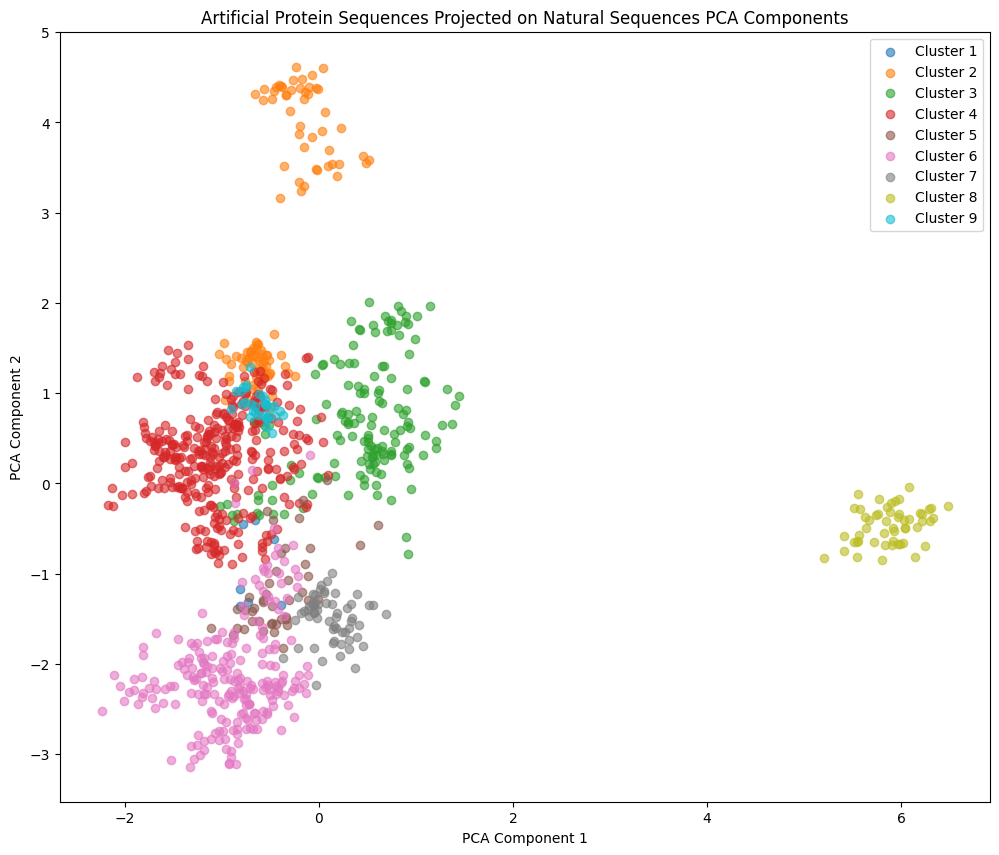

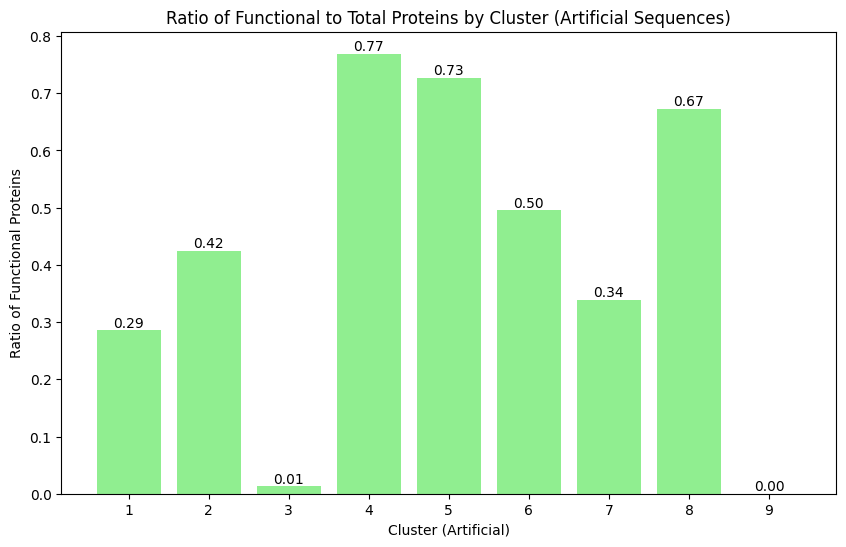

In [ ]:
#now I take the clustering made onto the natural sequences with k=9 and I apply it to the artificial ones (and project onto the 2 pcs of the natural).
#this is done to assess if the clustering for the natural is also "successful" for the artificial sequences.
#we also compute the fractions of functional artificial proteins in such configuration.
kmeans = KMeans(n_clusters=9, random_state=42)
kmeans.fit(onehot_nat)

pca = PCA(n_components=2)
pca.fit(onehot_nat)
pca_nat = pca.transform(onehot_nat)
pca_art = pca.transform(onehot_art)

# Swith .predict I assign the clustering done on the natural onto the onehot_art (artificial)
clusters_art = kmeans.predict(onehot_art)

cluster_info_art = []

for cluster in range(9):
    indices_art = clusters_art == cluster
    total_proteins_art = sum(indices_art)
    functional_proteins_art = sum(labels_art[indices_art] == 1)
    non_functional_proteins_art = sum(labels_art[indices_art] == 0)
    ratio_functional_art = functional_proteins_art / total_proteins_art if total_proteins_art > 0 else 0

    cluster_info_art.append((total_proteins_art, functional_proteins_art, non_functional_proteins_art, ratio_functional_art))

for idx, (total, func, non_func, ratio) in enumerate(cluster_info_art):
    print(f"Cluster {idx+1} (Artificial):")
    print(f"  Total Proteins: {total}")
    print(f"  Functional Proteins: {func}")
    print(f"  Non-Functional Proteins: {non_func}")
    print(f"  Functional/Total Ratio: {ratio:.2f}")
    print()

colors = plt.cm.tab10(np.linspace(0, 1, 9))

plt.figure(figsize=(12, 10))

for cluster in range(9):
    cluster_indices = clusters_art == cluster
    plt.scatter(pca_art[cluster_indices, 0], pca_art[cluster_indices, 1],
                color=colors[cluster], label=f'Cluster {cluster+1}', alpha=0.6)

plt.title('Artificial Protein Sequences Projected on Natural Sequences PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

ratios_art = [info[3] for info in cluster_info_art]

plt.figure(figsize=(10, 6))
plt.bar(range(1, 10), ratios_art, color='lightgreen')

plt.xlabel('Cluster (Artificial)')
plt.ylabel('Ratio of Functional Proteins')
plt.title('Ratio of Functional to Total Proteins by Cluster (Artificial Sequences)')
plt.xticks(range(1, 10))

for idx, ratio in enumerate(ratios_art):
    plt.text(idx + 1, ratio, f"{ratio:.2f}", ha='center', va='bottom')

plt.show()
#also here, the cluster number 9 contains only non-functional artificial sequences.

<ipython-input-164-db19a7fb8915>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 9)  # Using 'viridis' colormap with 9 discrete colors


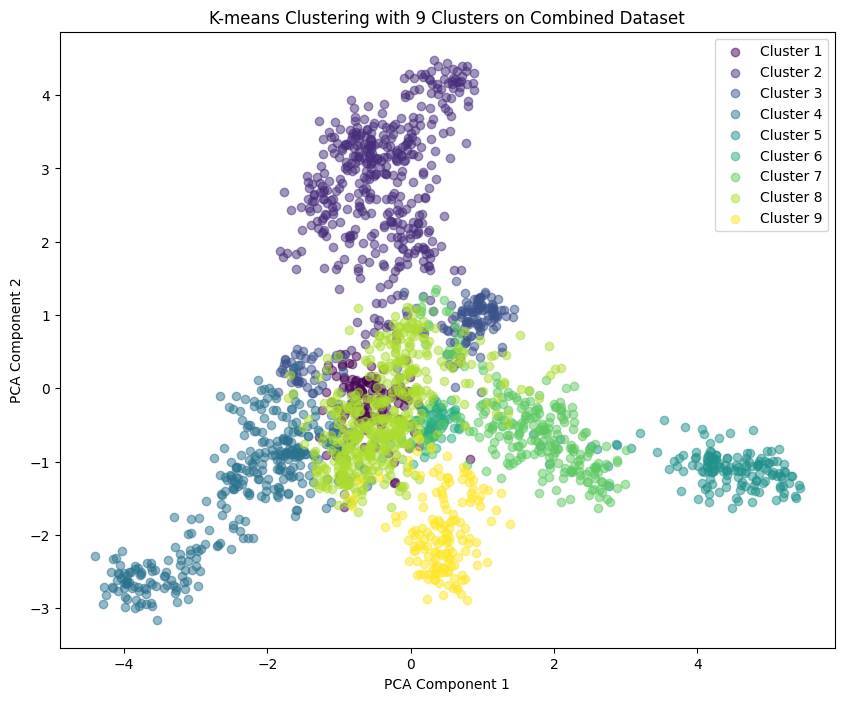

In [ ]:
#Now I combine all proteins togheter, both natural and artificial. I apply kmeans to all of them.
#I project onto the 2 principal components of all the sequences: the reason is that I'm no more interested to see how artificial sequences are "similar" to natural ones.
#Indeed, here I'm interested to look at how artificial/natural and functional/non-functional sequences are globally separated.

#I combine onehot_nat and onehot_art
onehot_tot = np.vstack([onehot_nat, onehot_art])

# Perform k-means clustering with k=9 on onehot_tot (still, we have to check the optimal number of clusters)
kmeans_tot = KMeans(n_clusters=9, random_state=42,n_init=20)
clusters_tot = kmeans_tot.fit_predict(onehot_tot)

pca_tot = PCA(n_components=2)
pca_tot.fit(onehot_tot)
pca_reduced_tot = pca_tot.transform(onehot_tot)

plt.figure(figsize=(10, 8))
cmap = plt.cm.get_cmap('viridis', 9)

for cluster in range(9):
    cluster_indices = clusters_tot == cluster
    plt.scatter(pca_reduced_tot[cluster_indices, 0], pca_reduced_tot[cluster_indices, 1],
                color=cmap(cluster), label=f'Cluster {cluster+1}', alpha=0.5)

plt.title('K-means Clustering with 9 Clusters on Combined Dataset')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()
#The plot is nice, but maybe 9 clusters are not enough here.

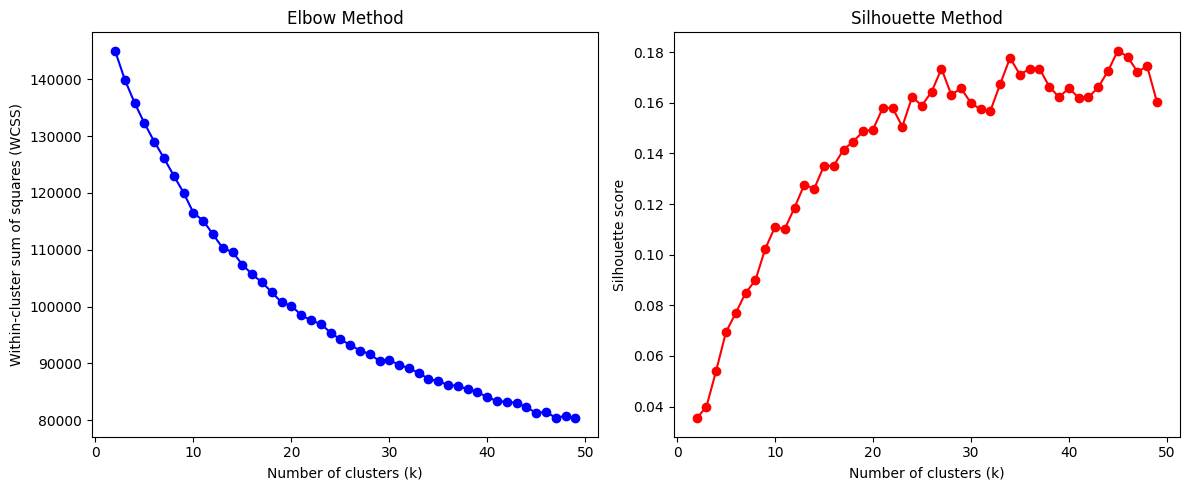

In [ ]:
#We again plot the scree plot and the silhouette score and we see that the optimal number of clusters lies between 18 and 22, approximately.

k_values = range(2, 50)
elbow_method = []
silhouette_method = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    kmeans.fit(onehot_tot)

    # within-cluster sum of squares
    elbow_method.append(kmeans.inertia_)

    # Silhouette method
    if len(set(kmeans.labels_)) > 1:
        silhouette_avg = silhouette_score(onehot_tot, kmeans.labels_)
        silhouette_method.append(silhouette_avg)
    else:
        silhouette_method.append(None)

#scree prot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, elbow_method, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.title('Elbow Method')

# Silhouette score plot
plt.subplot(1, 2, 2)
filtered_k_values = [k for k, silhouette in zip(k_values, silhouette_method) if silhouette is not None]
filtered_silhouette_method = [silhouette for silhouette in silhouette_method if silhouette is not None]
plt.plot(filtered_k_values, filtered_silhouette_method, 'ro-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.tight_layout()
plt.show()


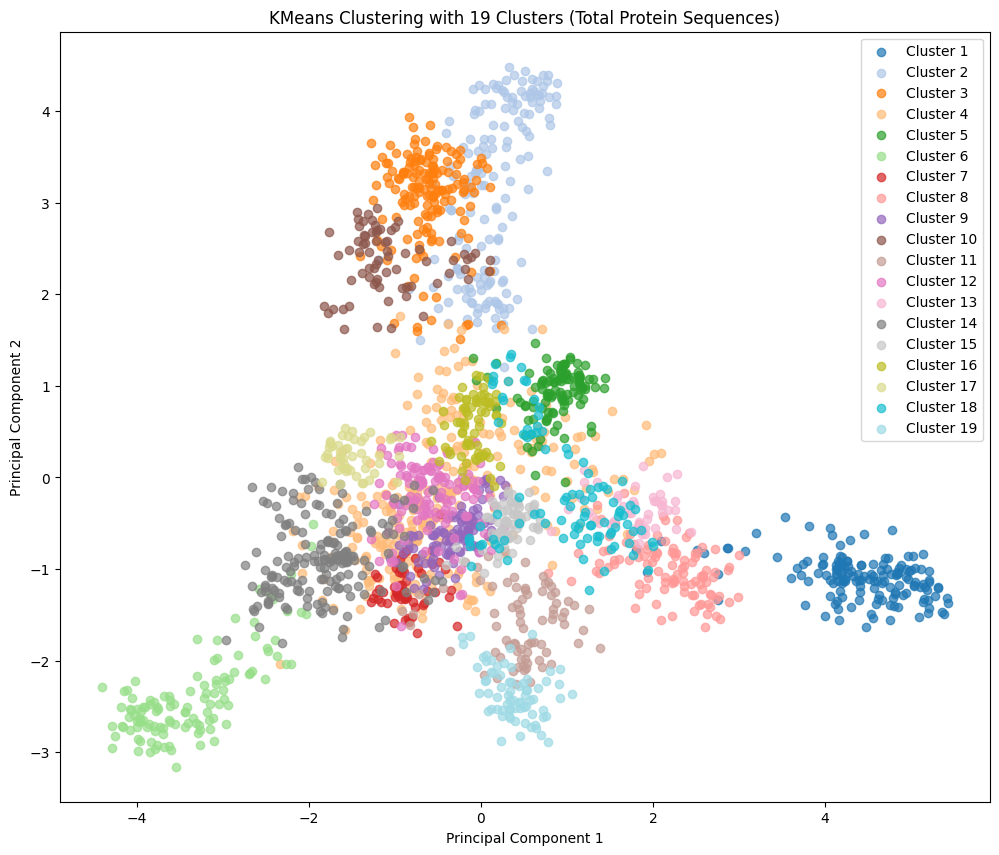

In [ ]:
#redo kmeans to the total dataset with 19 clusters and project onto the 2 principal components.
kmeans_tot = KMeans(n_clusters=19, random_state=42,n_init=20)
onehot_tot = np.vstack([onehot_nat, onehot_art])
clusters_tot = kmeans_tot.fit_predict(onehot_tot)

pca_tot = PCA(n_components=2)
pca_tot_result = pca_tot.fit_transform(onehot_tot)

plt.figure(figsize=(12, 10))

colors = plt.cm.tab20(np.linspace(0, 1, 19))

for cluster in range(19):
    cluster_indices = clusters_tot == cluster
    plt.scatter(pca_tot_result[cluster_indices, 0], pca_tot_result[cluster_indices, 1],
                color=colors[cluster], label=f'Cluster {cluster+1}', alpha=0.7)

plt.title('KMeans Clustering with 19 Clusters (Total Protein Sequences)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(markerscale=1)
plt.show()

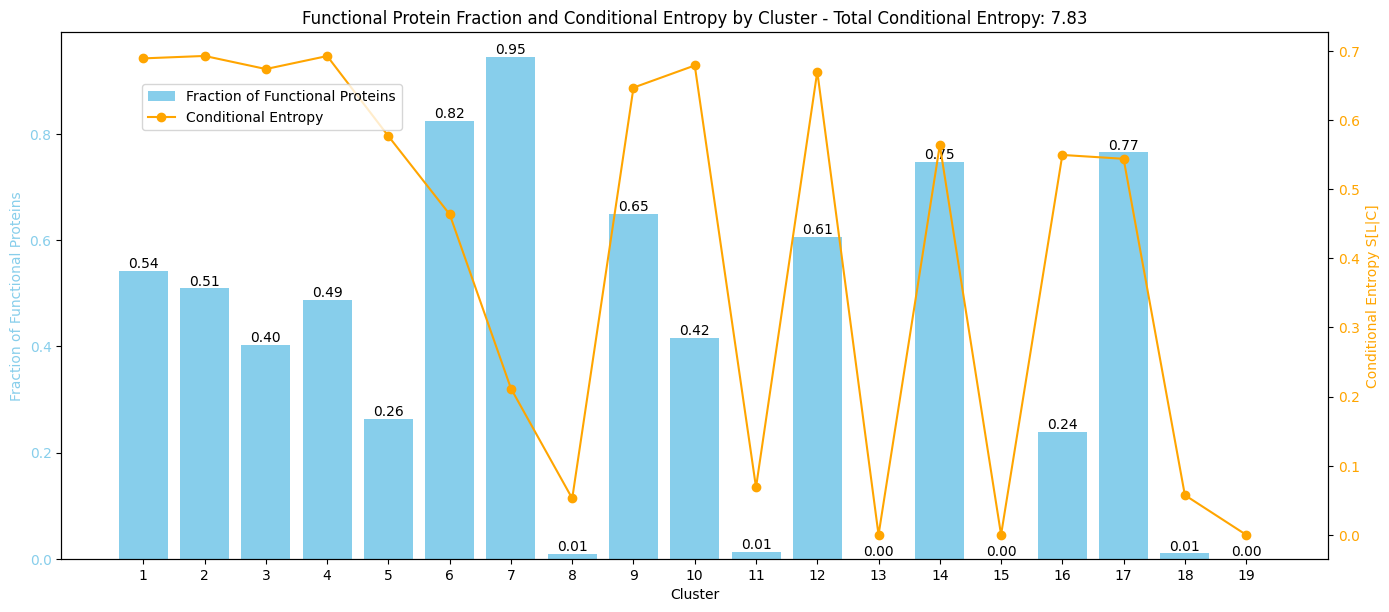

In [ ]:
#Now I want to assess how globally functional and non-functional proteins are separated (regardless by their feature natural/artificial).
#Also, I want to see how artificial/natural proteins are separated with clustering.
#My questions are then: are this clusters actually separating our dataset onto natural/artificial and functional/nonfunctional? which is better easily separable of the two features?
#I also would like to have a global measure that tells me which of these two features is better separated by kmeans (natural/artificial or functional/non-functional).
#to do so, I first plot the empirical frequences (bar plot) for "naturality" and functionality.
#To the separation done by kmeans with 19 clusters, I compute the conditional probabilities p(L|C) (probability to have festure L given the sequence belongs in cluster C).
#I then compute the conditional entropy both for L=functional/nonfunctional and L=artificial/natural.
#In this way, I found that kmeans with 19 cluster has been able to better separate functionalities rather than natural/artificial.
#this can also be seen as the fact that the artificial sequences hasve been sampled effectively.

labels_tot = np.concatenate([labels_nat, labels_art])

kmeans = KMeans(n_clusters=19, random_state=42, n_init=20)
clusters = kmeans.fit_predict(onehot_tot)

conditional_entropies = []
functional_ratios = []

for cluster in range(19):
    indices = clusters == cluster
    labels_in_cluster = labels_tot[indices]

    p_functional = np.mean(labels_in_cluster == 1)
    p_non_functional = np.mean(labels_in_cluster == 0)

    if p_functional > 0 and p_non_functional > 0:
        conditional_entropy = -p_functional * np.log(p_functional) - p_non_functional * np.log(p_non_functional)
    else:
        conditional_entropy = 0

    conditional_entropies.append(conditional_entropy)
    functional_ratios.append(p_functional)

# total conditional entropy for functional/non-functional.
total_conditional_entropy = sum(conditional_entropies)

# bar plot of the fraction of functional proteins and conditional entropy for each cluster
fig, ax1 = plt.subplots(figsize=(14, 6))
#clusters index from 1 to 19
clusters_index = range(1, 20)

ax1.bar(clusters_index, functional_ratios, color='skyblue', label='Fraction of Functional Proteins', align='center')
ax1.set_xlabel('Cluster')
ax1.set_xticks(clusters_index)
ax1.set_ylabel('Fraction of Functional Proteins', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

for idx, ratio in enumerate(functional_ratios):
    ax1.text(idx + 1, ratio, f"{ratio:.2f}", ha='center', va='bottom')

ax2 = ax1.twinx()
ax2.plot(clusters_index, conditional_entropies, color='orange', marker='o', linestyle='-', label='Conditional Entropy')
ax2.set_ylabel('Conditional Entropy S[L|C]', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

fig.tight_layout()
plt.title(f'Functional Protein Fraction and Conditional Entropy by Cluster - Total Conditional Entropy: {total_conditional_entropy:.2f}')
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

plt.show()


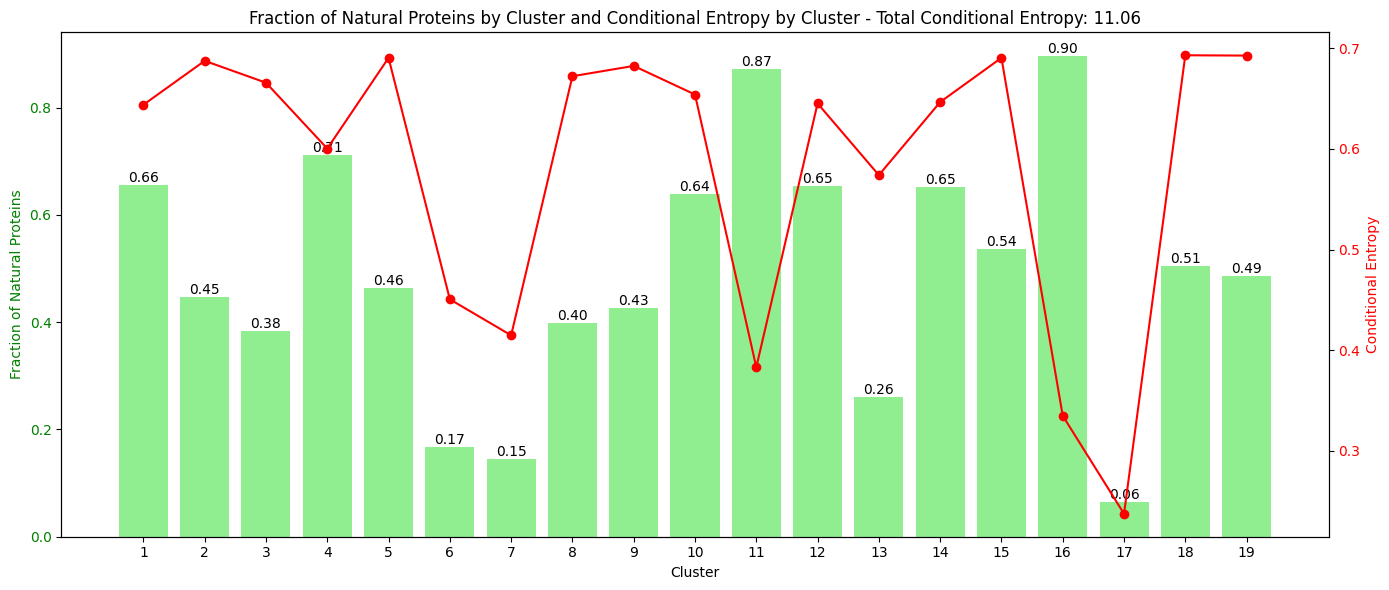

In [ ]:
#I do the same plot but for artificial/natural
# Creating labels_natart with 1 for natural proteins and 0 for artificial proteins
labels_natart = np.concatenate([np.ones(1130), np.zeros(1003)])

kmeans = KMeans(n_clusters=19, random_state=42,n_init=20)
clusters = kmeans.fit_predict(onehot_tot)

nat_art_ratios = []
conditional_entropies_nat_art = []

# Loop through clusters to calculate fractions and contitional entropies
for cluster in range(19):
    indices = clusters == cluster
    labels_in_cluster = labels_natart[indices]

    p_nat = np.mean(labels_in_cluster == 1)
    p_art = np.mean(labels_in_cluster == 0)

    if p_nat > 0 and p_art > 0:
        conditional_entropy = -p_nat * np.log(p_nat) - p_art * np.log(p_art)
    else:
        conditional_entropy = 0

    nat_art_ratios.append(p_nat)
    conditional_entropies_nat_art.append(conditional_entropy)

# Total conditional entropy
total_conditional_entropy_artnat = sum(conditional_entropies_nat_art)

fig, ax1 = plt.subplots(figsize=(14, 6))

bars = ax1.bar(range(1, 20), nat_art_ratios, color='lightgreen', label='Fraction of Natural Proteins', align='center')
ax1.set_xlabel('Cluster')
ax1.set_xticks(range(1, 20))
ax1.set_ylabel('Fraction of Natural Proteins', color='green')
ax1.tick_params(axis='y', labelcolor='green')

for bar, ratio in zip(bars, nat_art_ratios):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f"{ratio:.2f}", ha='center', va='bottom')

ax2 = ax1.twinx()
ax2.plot(range(1, 20), conditional_entropies_nat_art, 'ro-')
ax2.set_ylabel('Conditional Entropy', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title(f'Fraction of Natural Proteins by Cluster and Conditional Entropy by Cluster - Total Conditional Entropy: {total_conditional_entropy_artnat:.2f}')
plt.tight_layout()
plt.show()

#the total value of the conditional entropy is 11.06 (L=natural/artificial) versus 7.83 (L=functional/nonfunctional).
#this means that for kmeans, in this framework, it was "easier" to separate functionality rather than artificial/natural.

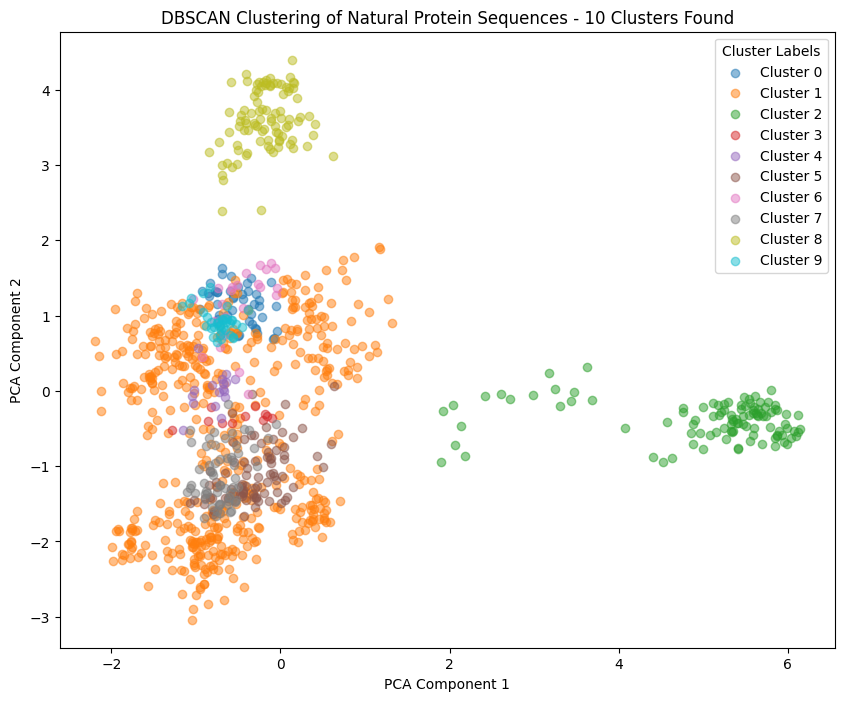

In [ ]:
#Let's apply a different clustering technique, in particular a density based one (DBSCAN here).
# Apply DBSCAN to the natural sequences first.
dbscan_nat = DBSCAN(eps=10.6, min_samples=9).fit(onehot_nat)

cluster_labels_nat = dbscan_nat.labels_

unique_labels = np.unique(cluster_labels_nat)

# In the following plots I decided to exclude noise by filtering out -1, but keeping into account the amount of datapoints that were classified as noise.
unique_labels = unique_labels[unique_labels != -1]
num_clusters = len(unique_labels)

colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))

plt.figure(figsize=(10, 8))

for cluster_label, color in zip(unique_labels, colors):
    mask = (cluster_labels_nat == cluster_label)
    plt.scatter(pca_2d_nat[mask, 0], pca_2d_nat[mask, 1], color=color, label=f'Cluster {cluster_label}', alpha=0.5)

plt.title(f'DBSCAN Clustering of Natural Protein Sequences - {num_clusters} Clusters Found')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title="Cluster Labels")
plt.show()
#the clustering found is not satisfactory at all for the "bulk" region of the natural sequences.
#However, tuning the hyperparameters, the number of clusters found by dbscan is consistent with the optimal number of clusters found before.


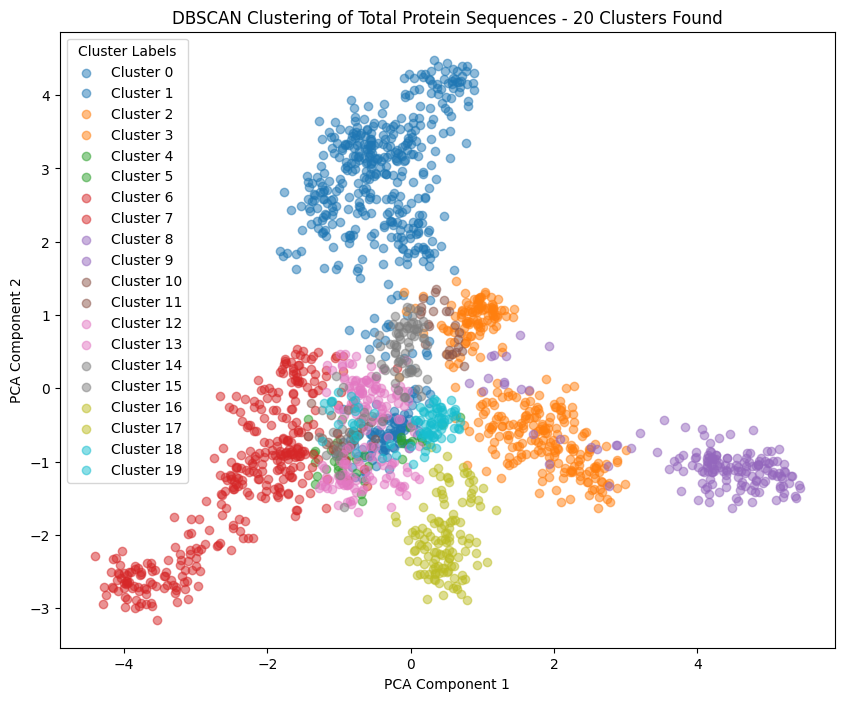

In [ ]:
#Now let's apply DBSCAN to the onehot_tot dataset (total sequences)
dbscan_tot = DBSCAN(eps=9.8, min_samples=10).fit(onehot_tot)

cluster_labels_tot = dbscan_tot.labels_

unique_labels_tot = np.unique(cluster_labels_tot)
unique_labels_tot = unique_labels_tot[unique_labels_tot != -1]
num_clusters_tot = len(unique_labels_tot)

pca_tot = PCA(n_components=2).fit_transform(onehot_tot)

colors_tot = plt.cm.tab10(np.linspace(0, 1, num_clusters_tot))

plt.figure(figsize=(10, 8))

for cluster_label, color in zip(unique_labels_tot, colors_tot):
    mask = (cluster_labels_tot == cluster_label)
    plt.scatter(pca_tot[mask, 0], pca_tot[mask, 1], color=color, label=f'Cluster {cluster_label}', alpha=0.5)

plt.title(f'DBSCAN Clustering of Total Protein Sequences - {num_clusters_tot} Clusters Found')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title="Cluster Labels")
plt.show()
#This clustering is similar to kmeans (20 clusters found) but different clusters are better separated overall.

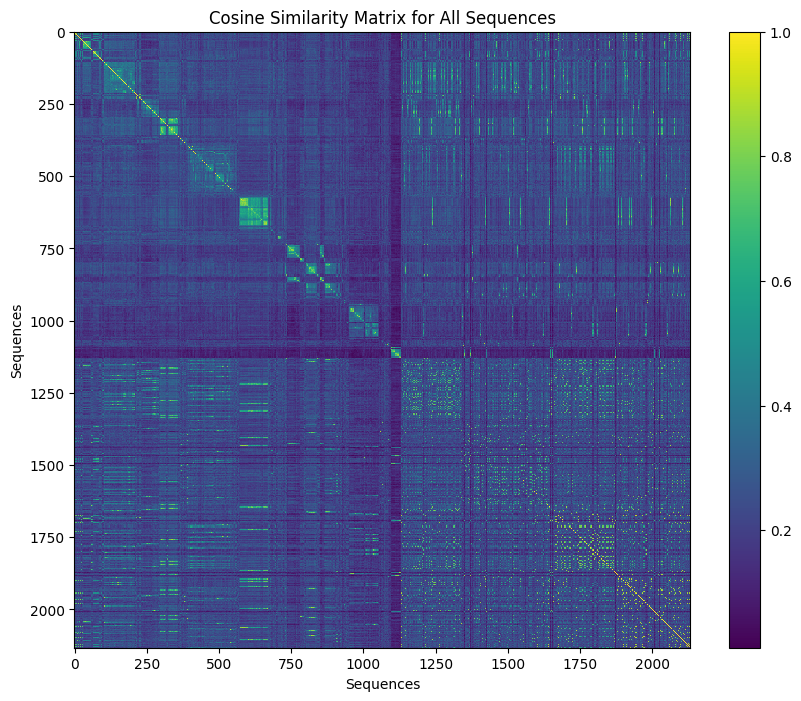

In [ ]:
# Lastly, I computed the cosine similarity matrix for the total sequences, hoping to get a hint for projecting onto the umap components or not.
cos_sim_matrix_tot = cosine_similarity(onehot_tot, onehot_tot)
plt.figure(figsize=(10, 8))
plt.imshow(cos_sim_matrix_tot, cmap='viridis', interpolation='none')
plt.colorbar()
plt.title('Cosine Similarity Matrix for All Sequences')
plt.xlabel('Sequences')
plt.ylabel('Sequences')
plt.show()
#from this matrix I thought that artificial sequences do not show the same block structure of the natural ones but are much more blurried.
#Indeed, I tried to project the total sequences and the clustering found by DBSCAN onto the 2 umap components but the results, even though a lot of trial and error, were not satisfactory.

# Classification Tasks

Task 4: Predicting protein functionality
Use a classifer of your choice (e.g. logistic regression, but you could use random forest, neural networks etc.) to learn
a function mapping sequences to functionality, i.e. to a binary output, using the training MSA of natural sequences.
Test this classifer using the artifcial test data, too. Determine the numbers of predictions which are true positives
(TP – functional sequences predicted to be functional), false postives (FP – nonfunctional sequences predicted to be
functional), true negatives (TN – nonfunctional sequences predicted to be nonfunctional) and false negatives (FN
– functional sequences predicted to be nonfunctional). Compare them for training and test data. Note that for lo-
gistic regression, as for any soft classifer, these quantities are functions of a cutof used to achieve a hard classifcation.


In [ ]:
#2 approaches are possible in this task. I could use first only the natural sequences as my train,validation (to choose the hyperparameters) and test set (usually 70%,15% and 15%).
#Or I could use the natural sequences as my training and validation set (80% and 20%) and all the artificial ones for testing.
#I chose this second option since at this stage I care about the labels of my sequences (functional/non-functional) and as it was
#specified in the course, the artificial proteins were tested in real life and their label is as much "true" as the natural labels.

# Splitting the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(onehot_nat, labels_nat, test_size=0.2, random_state=42)

# Setting all the artificial sequences as the test set
X_test = onehot_art
y_test = labels_art


In [ ]:
X_train.shape

(904, 1920)

In [ ]:
y_train.shape

(904,)

In [ ]:
X_valid.shape

(226, 1920)

In [ ]:
y_valid.shape

(226,)

Accuracy on Training Set: 1.0000


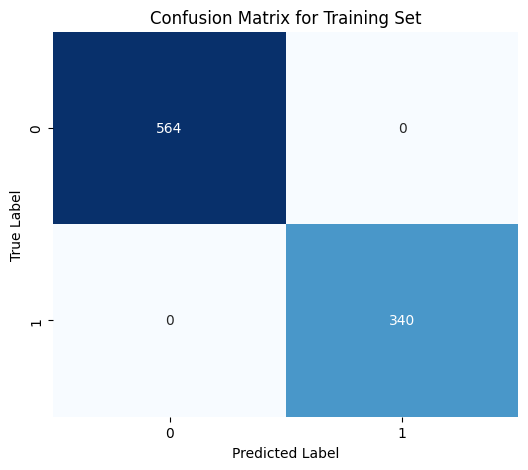

In [ ]:
# I begin with a logistic regression. At this stage, I take it as simple as I can and then I will use more sophisticated methods to see if it actually improves.

#Initialize and train logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predictions on the training set to see how it has trained.
y_train_pred = log_reg.predict(X_train)

# Calculate accuracy on the training set and with no wonder it is 100%
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f"Accuracy on Training Set: {accuracy_train:.4f}")

# Plotting the confusion matrix for the training set. Remember 0=nonfunctional and 1=functional.
cm_train = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Training Set')
plt.show()

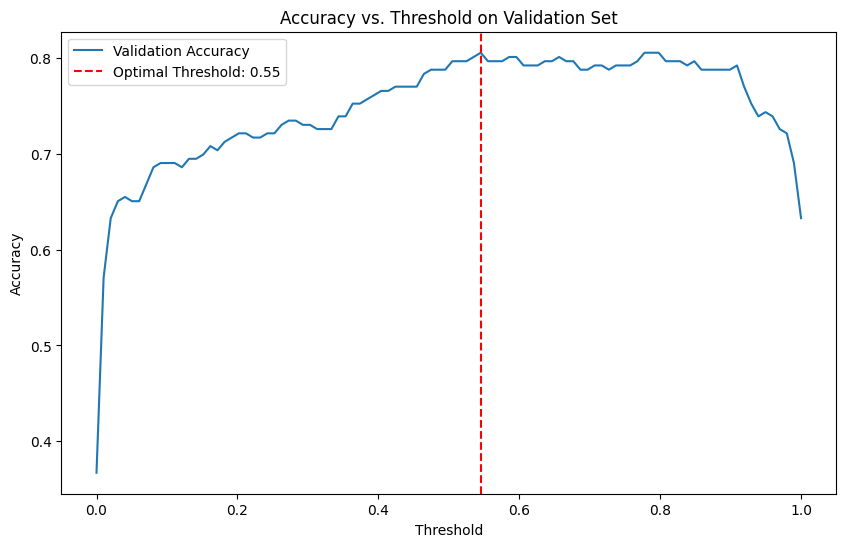

Optimal Threshold: 0.55


In [ ]:
#logistic regression is a soft classifier (it returns as output a probability of a given label given the data point)
#as we know, any soft classifier can be turned into a hard one (returns the assignment of the label, i.e. 0 or 1) by setting a threshold (previously, if you do not indicate anything the threshold is set to 0.5)

#let's choose the optimal threshold using ONLY the validation set
y_valid_prob = log_reg.predict_proba(X_valid)[:, 1]

thresholds = np.linspace(0, 1, 100)
accuracy_scores = []

# Calculate the accuracy for each threshold on the validation set and predictions
for threshold in thresholds:
    y_pred_threshold = (y_valid_prob >= threshold).astype(int)
    accuracy = accuracy_score(y_valid, y_pred_threshold)
    accuracy_scores.append(accuracy)

# Find the threshold that gives the maximum accuracy
max_accuracy_index = np.argmax(accuracy_scores)
optimal_threshold = thresholds[max_accuracy_index]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy_scores, label='Validation Accuracy')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold on Validation Set')
plt.legend()
plt.show()

print(f"Optimal Threshold: {optimal_threshold:.2f}")

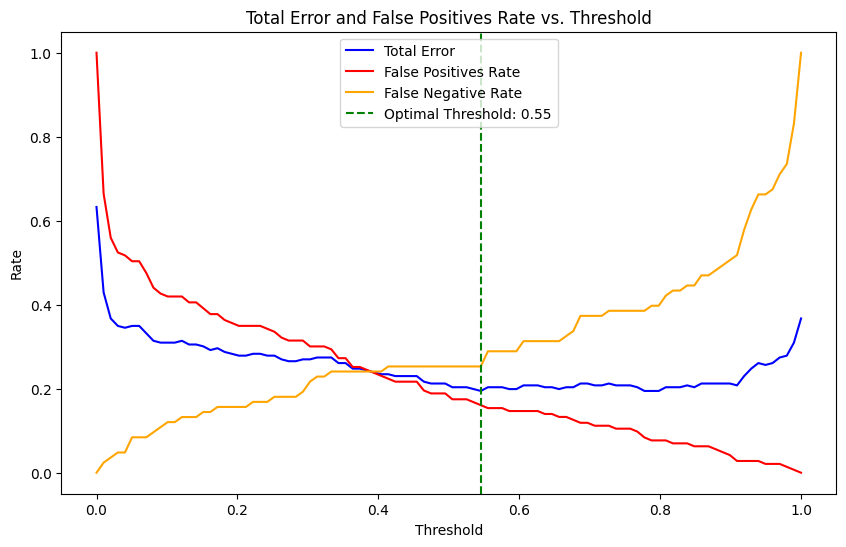

In [ ]:
#Here I plot the total error in the validation set by changing the threshold, as well as the false positive/negative rates.
def plot_total_error_false_positives(y_true, y_scores, optimal_threshold):
    thresholds = np.linspace(0, 1, 100)
    total_errors = []
    false_positives_rates = []
    false_negatives_rates = []

    for t in thresholds:
        y_pred_threshold = (y_scores >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_threshold).ravel()

        total_error = 1 - accuracy_score(y_true, y_pred_threshold)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        false_negatives_rates.append(fnr)
        total_errors.append(total_error)
        false_positives_rates.append(fpr)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, total_errors, label='Total Error', color='blue')
    plt.plot(thresholds, false_positives_rates, label='False Positives Rate', color='red')
    plt.plot(thresholds, false_negatives_rates, label='False Negative Rate', color='orange')

    plt.axvline(x=optimal_threshold, color='green', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Rate')
    plt.title('Total Error and False Positives Rate vs. Threshold')
    plt.legend()
    plt.show()

plot_total_error_false_positives(y_valid, y_valid_prob, optimal_threshold)

#the threshold found before actually coincides with the minimum of the total error.

Accuracy on Validation Set with Optimal Threshold: 0.8053


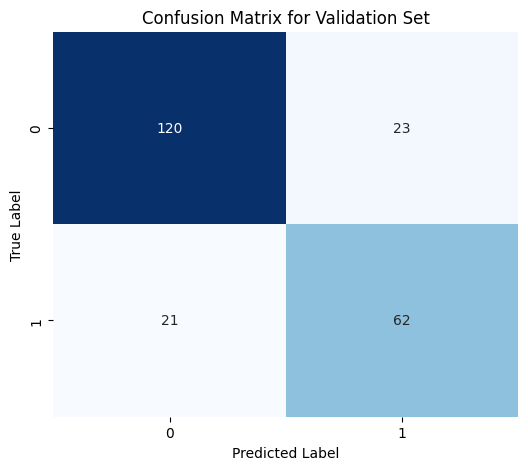

In [ ]:
# Apply the optimal threshold to validation predictions and print the accuracy on the validation set.
y_valid_pred_optimal = (y_valid_prob >= optimal_threshold).astype(int)

accuracy_optimal = accuracy_score(y_valid, y_valid_pred_optimal)
print(f"Accuracy on Validation Set with Optimal Threshold: {accuracy_optimal:.4f}")

# Plotting the confusion matrix for the validation set with optimal threshold.
cm_valid = confusion_matrix(y_valid, y_valid_pred_optimal)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_valid, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation Set')
plt.show()


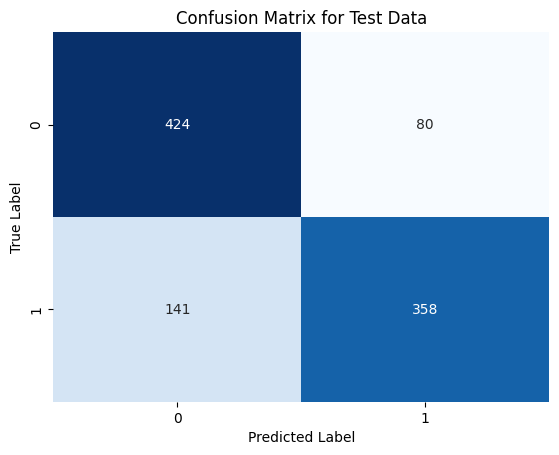

Accuracy on Test Data: 0.7797
F1 Score on Test Data: 0.7641


In [ ]:
# Here I plot the confusion matrix and the accuracy and F1 score for the test set AFTER I chose the optimal threshold.
#It is the first time my logistic regretion "sees" the test set.

y_test_prob = log_reg.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob >= optimal_threshold).astype(int)

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_test_pred, title='Confusion Matrix for Test Data')

def print_scores(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy on Test Data: {accuracy:.4f}")
    print(f"F1 Score on Test Data: {f1:.4f}")

print_scores(y_test, y_test_pred)


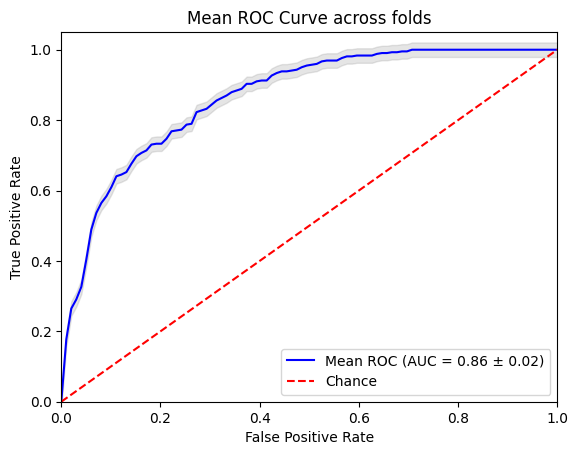

Mean optimal threshold across folds: 0.60


In [ ]:
# Here we do another logistic regression from zero, but we use a more sophisticated approach.
#We add both Ridge and Lasso regularizations with elasticnet, and we plot the ROC curve.
#The area under the roc curves gives a global output for estimating the quality of my classifier, as it takes into account both TPR, FPR and thresholds.

log_reg = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga', max_iter=5000, random_state=42)
#Imp: we build the roc curve by a stratified 6-fold cross validation on the whole natural sequences. In this way we get a "mean" roc curve.
n_splits = 6
cv = StratifiedKFold(n_splits=n_splits, shuffle=True) #shuffle=True is important

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
optimal_thresholds = []

for train_idx, test_idx in cv.split(onehot_nat, labels_nat):
    X_train_cv, X_test_cv = onehot_nat[train_idx], onehot_nat[test_idx]
    y_train_cv, y_test_cv = labels_nat[train_idx], labels_nat[test_idx]

    log_reg.fit(X_train_cv, y_train_cv)
    probas_ = log_reg.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test_cv, probas_)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(auc(fpr, tpr))

    #The point of the roc curve which is more distance from the diagonal (TPR=FPR) identifies the best threshold for this fold.
    accuracies = [accuracy_score(y_test_cv, probas_ >= threshold) for threshold in thresholds]
    optimal_idx = np.argmax(accuracies)
    optimal_thresholds.append(thresholds[optimal_idx])

# mean ROC and std
mean_tpr_log = np.mean(tprs, axis=0)
mean_tpr_log[-1] = 1.0
mean_auc_log = auc(mean_fpr, mean_tpr_log)
std_auc_log = np.std(aucs)

# Average optimal thresholds across folds to get the "mean optimal threshold".
mean_optimal_threshold = np.mean(optimal_thresholds)

plt.plot(mean_fpr, mean_tpr_log, color='blue', label=f'Mean ROC (AUC = {mean_auc_log:.2f} ± {std_auc_log:.2f})')
plt.fill_between(mean_fpr, mean_tpr_log - std_auc_log, mean_tpr_log + std_auc_log, color='grey', alpha=0.2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve across folds')
plt.legend(loc="lower right")
plt.show()

print(f'Mean optimal threshold across folds: {mean_optimal_threshold:.2f}')


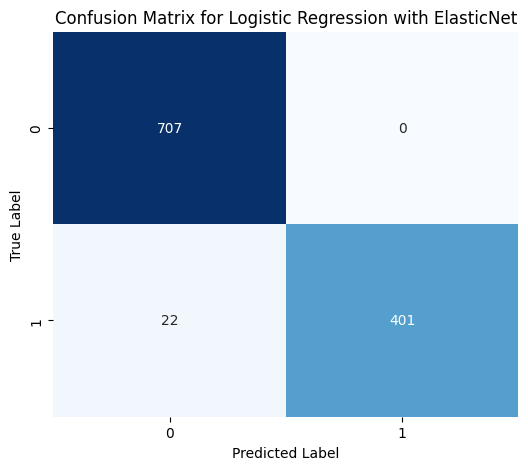

Accuracy: 0.9805
F1 Score: 0.9733


In [ ]:
# After this step, we train a new logistic regression (identical to the previous one) with both regulatizations and with the mean optimal threshold found before.
# In this way, we can see if a more "sophisticated" approach can arise to a better accuracy on the test set.
X = onehot_nat
y = labels_nat

# Train logistic regression with elasticnet regularization on the entire natural sequences. (Before we used 6-fold CV).
log_reg = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga', max_iter=5000, random_state=42)
log_reg.fit(X, y)

y_prob = log_reg.predict_proba(X)[:, 1]

# Apply the mean optimal threshold
y_pred = (y_prob >= mean_optimal_threshold).astype(int)

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, "Confusion Matrix for Logistic Regression with ElasticNet")

accuracy = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
#accuracy on train set is of course high. LEt's see on the test set after this cell, on the artificial sequences.


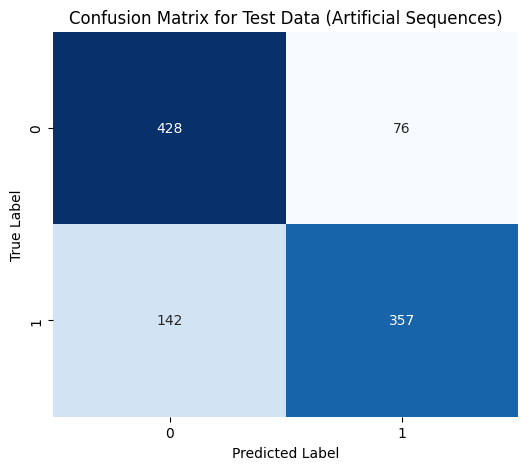

Test Accuracy: 0.7827
Test F1 Score: 0.7661


In [ ]:
X_test = onehot_art
y_test = labels_art

# predict on the test set
y_test_prob = log_reg.predict_proba(X_test)[:, 1]

# use the mean optimal threshold to classify predictions
y_test_pred = (y_test_prob >= mean_optimal_threshold).astype(int)

cm_test = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm_test, "Confusion Matrix for Test Data (Artificial Sequences)")

accuracy_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"Test Accuracy: {accuracy_test:.4f}")
print(f"Test F1 Score: {f1_test:.4f}")
#test set accuracy is 78%, higher than the previous "naive" logistic regression but very slightly (often in physics, less is more!).

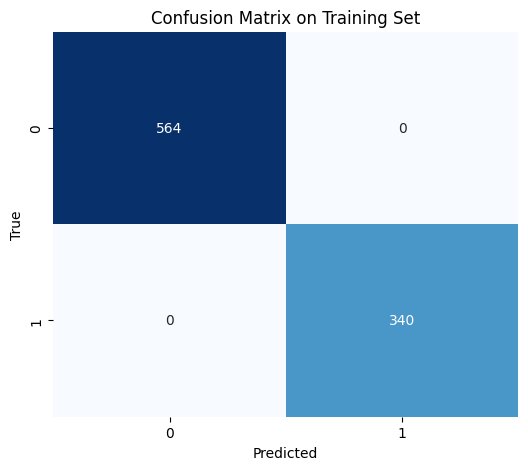

Accuracy on Training Set: 1.0
F1 Score on Training Set: 1.0


In [ ]:
#Let's use now a Random Forest classifier.

# Train the RandomForestClassifier, in this first one I take default max_depth and 100 estimators.
rf = RandomForestClassifier(bootstrap=True, n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)

#confusion matrix for training set
cm = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Training Set')
plt.show()

print("Accuracy on Training Set:", accuracy_score(y_train, y_train_pred))
print("F1 Score on Training Set:", f1_score(y_train, y_train_pred))


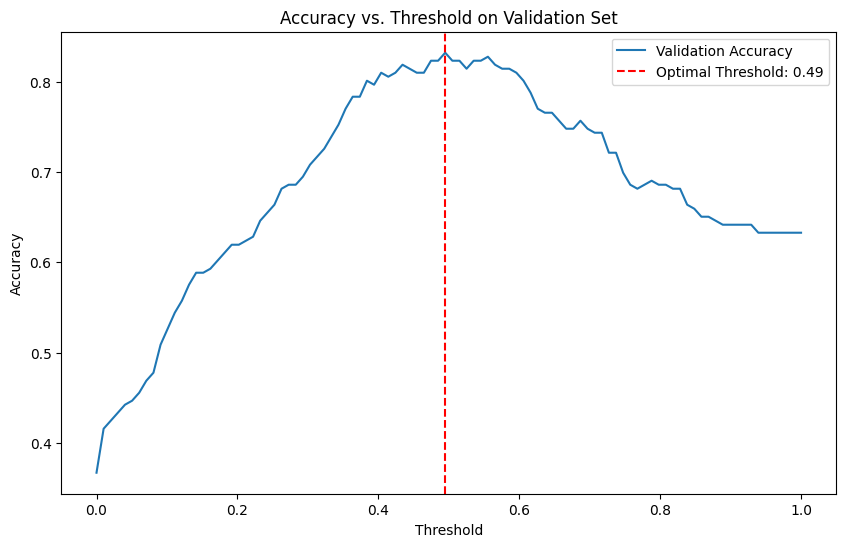

In [ ]:
# Use only the validation set now.
y_valid_prob = rf.predict_proba(X_valid)[:, 1]

thresholds = np.linspace(0, 1, 100)
accuracy_scores = [accuracy_score(y_valid, y_valid_prob >= t) for t in thresholds]

optimal_threshold_idx = np.argmax(accuracy_scores)
optimal_threshold = thresholds[optimal_threshold_idx]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy_scores, label='Validation Accuracy')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold on Validation Set')
plt.legend()
plt.show()


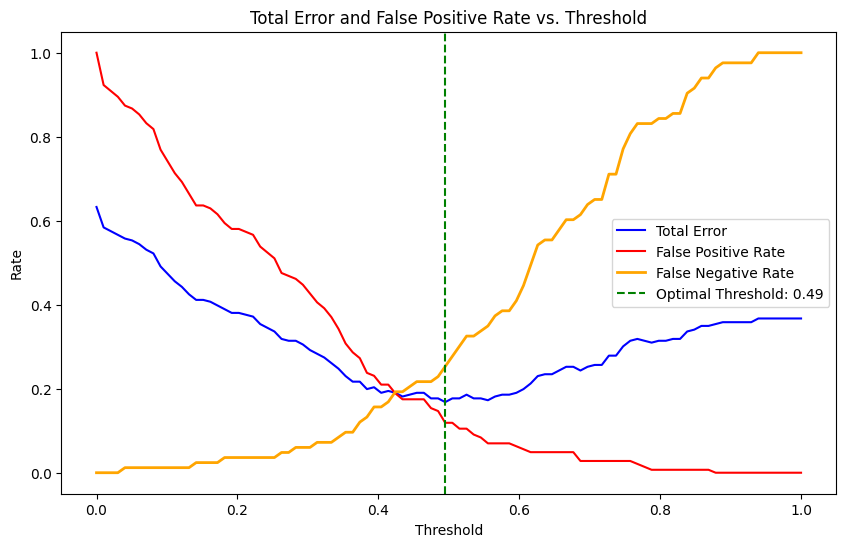

In [ ]:
total_errors = []
false_positives_rates = []
false_negatives_rates = []


for threshold in thresholds:
    y_pred_threshold = (y_valid_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_threshold).ravel()

    #total error
    total_error = (fp + fn) / (tp + tn + fp + fn)
    total_errors.append(total_error)
    #false positive rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    false_positives_rates.append(fpr)
    #false negative rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    false_negatives_rates.append(fnr)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, total_errors, label='Total Error', color='blue')
plt.plot(thresholds, false_positives_rates, label='False Positive Rate', color='red')
plt.plot(thresholds, false_negatives_rates, label='False Negative Rate', color='orange', linewidth=2)
plt.axvline(x=optimal_threshold, color='green', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('Total Error and False Positive Rate vs. Threshold')
plt.legend()
plt.show()


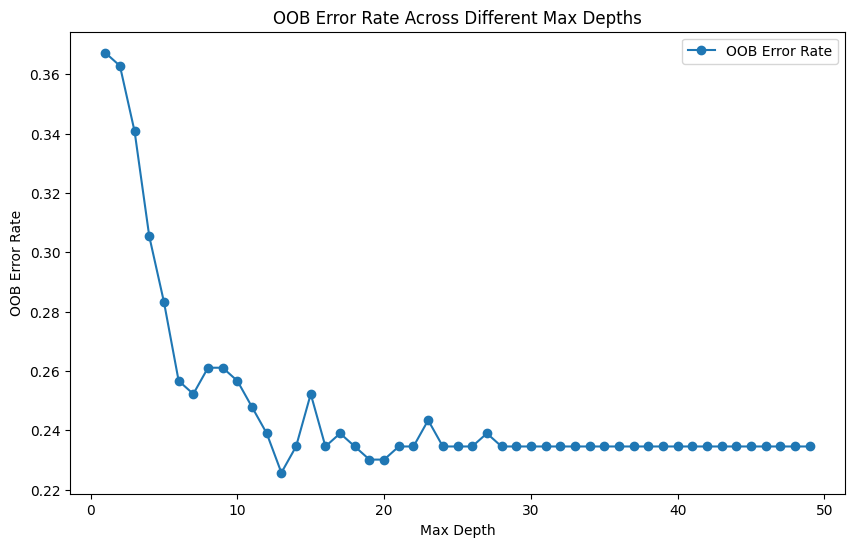

Optimal Max Depth: 13


In [ ]:
# Now, I plot and fine the minimum of the out of bag error to choose the optimal `max_depth` for my random forest.
#I still use the validation set.
depth = np.arange(1, 50)
oob_error = np.zeros(len(depth))

for i, d in enumerate(depth):
    model = RandomForestClassifier(bootstrap=True, max_depth=d, oob_score=True, n_estimators=500, random_state=42)
    model.fit(X_valid, y_valid)
    oob_error[i] = 1 - model.oob_score_

plt.figure(figsize=(10, 6))
plt.plot(depth, oob_error, label='OOB Error Rate', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across Different Max Depths')
plt.legend()
plt.show()

# optimal `max_depth` is intended as the lowest out of bag error
optimal_depth = depth[np.argmin(oob_error)]
print(f"Optimal Max Depth: {optimal_depth}")

#new model with the optimal `max_depth` found through the out of bag error. We will also use in the next cell the optimal threshold found before.
optimal_model = RandomForestClassifier(bootstrap=True, max_depth=optimal_depth, oob_score=True, n_estimators=500, random_state=42)


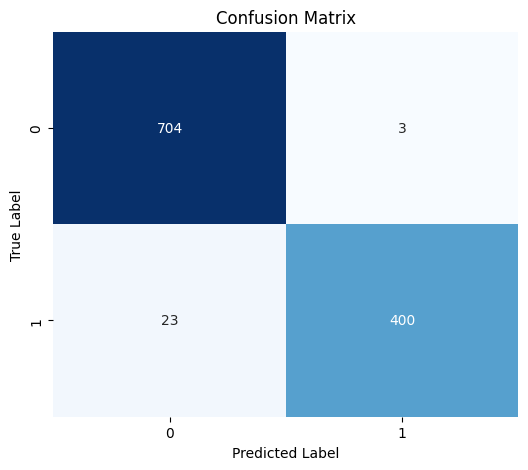

Accuracy: 0.9770
F1 Score: 0.9685


In [ ]:
optimal_model.fit(onehot_nat, labels_nat)

y_train_prob = optimal_model.predict_proba(onehot_nat)[:, 1]
y_train_pred = (y_train_prob >= optimal_threshold).astype(int)

accuracy = accuracy_score(labels_nat, y_train_pred)
f1 = f1_score(labels_nat, y_train_pred)

cm = confusion_matrix(labels_nat, y_train_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

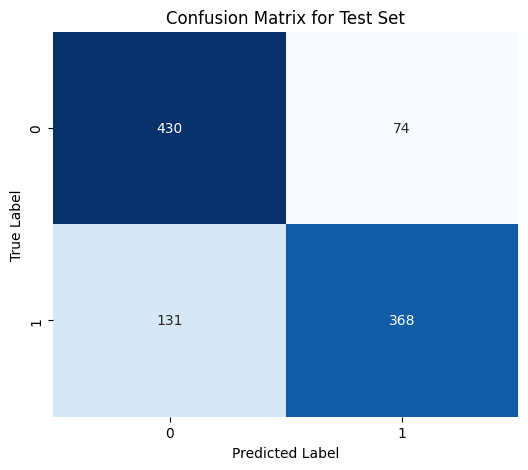

Accuracy on Test Set: 0.7956
F1 Score on Test Set: 0.7821


In [ ]:
# Predict probabilities on the test set and plot the confusion matrix and accuracy on the test set.
y_test_prob = optimal_model.predict_proba(X_test)[:, 1]

y_test_pred = (y_test_prob >= optimal_threshold).astype(int)

accuracy_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.show()

print(f"Accuracy on Test Set: {accuracy_test:.4f}")
print(f"F1 Score on Test Set: {f1_test:.4f}")
#Accuracy here is 79%, higher than logistic regression.

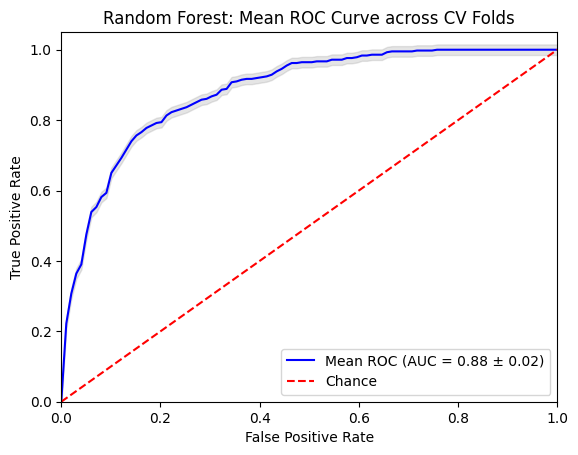

In [ ]:
#Also here, I plot the average ROC curve for the random forest, in order to assess globally its quality and compare it with the logistic regression done before.
#Also here I implement a stratified 6-fold cv over the natural sequences (that are divided into 5/6 train and 1/6 validation at each iteration).
n_splits = 6
cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for train_idx, test_idx in cv.split(onehot_nat, labels_nat):
    X_train_cv, X_test_cv = onehot_nat[train_idx], onehot_nat[test_idx]
    y_train_cv, y_test_cv = labels_nat[train_idx], labels_nat[test_idx]

    rf_classifier = RandomForestClassifier(bootstrap=True, n_estimators=500, random_state=42, max_depth=optimal_depth)
    rf_classifier.fit(X_train_cv, y_train_cv)

    probas_ = rf_classifier.predict_proba(X_test_cv)[:, 1]

    #ROC curve for the random forest.
    fpr, tpr, _ = roc_curve(y_test_cv, probas_)
    roc_auc = auc(fpr, tpr)

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)

#mean and standard deviation.
mean_tpr_forest = np.mean(tprs, axis=0)
mean_tpr_forest[-1] = 1.0
mean_auc_forest = auc(mean_fpr, mean_tpr_forest)
std_auc_forest = np.std(aucs)

plt.figure()
plt.plot(mean_fpr, mean_tpr_forest, color='blue', label=f'Mean ROC (AUC = {mean_auc_forest:.2f} ± {std_auc_forest:.2f})')
plt.fill_between(mean_fpr, mean_tpr_forest - std_auc_forest, mean_tpr_forest + std_auc_forest, color='grey', alpha=0.2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest: Mean ROC Curve across CV Folds')
plt.legend(loc="lower right")
plt.show()


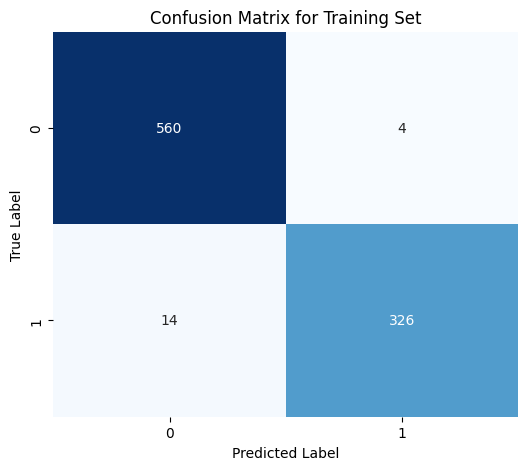

In [ ]:
#Let's implement now ADABOOST. I use logistic regressions as base estimators.
base_est = LogisticRegression()
ada_clf = AdaBoostClassifier(estimator=base_est, n_estimators=100, random_state=42)
ada_clf.fit(X_train, y_train)
# Predictions on the training set
y_train_pred = ada_clf.predict(X_train)

cm = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Training Set')
plt.show()
#the accuracy on the train set is not 100% as for the logistic and random forest. Anyway, we will focus on the predictive power.

In [ ]:
#Let's find the optimal hyperparameters on the validation set. Optimal parameters are the number of components and the learning rate.
%pip install scikit-learn
%pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.2 MB/s eta 0:00:00


In [ ]:
#To optimize the hyperparameters of Adaboost I used the library Optuna, following the steps that you can find in the link below:
#https://practicaldatascience.co.uk/machine-learning/how-to-create-and-tune-an-adaboost-classification-model
#this library proved very successful in my analysis. I used it just to try many different methods for different classifiers as an exercise and because it was fun!
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.datasets import load_wine
from sklearn.ensemble import AdaBoostClassifier
import optuna
from optuna.samplers import TPESampler
import pickle

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0, log=True)
    model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=1)
    model.fit(X_valid, y_valid)
    y_pred = model.predict(X_valid)
    return accuracy_score(y_valid, y_pred)

In [ ]:
sampler = TPESampler(seed=1)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100) #the command .optimize is important

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-02-04 22:23:15,218] A new study created in memory with name: no-name-8480930b-213e-4bbe-87b2-ef0437f21200
[I 2024-02-04 22:23:17,711] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 238, 'learning_rate': 0.14486833887239342}. Best is trial 0 with value: 1.0.
[I 2024-02-04 22:23:18,060] Trial 1 finished with value: 0.7345132743362832 and parameters: {'n_estimators': 50, 'learning_rate': 0.008072307884499755}. Best is trial 0 with value: 1.0.
[I 2024-02-04 22:23:18,842] Trial 2 finished with value: 0.6902654867256637 and parameters: {'n_estimators': 116, 'learning_rate': 0.0018924123965722254}. Best is trial 0 with value: 1.0.
[I 2024-02-04 22:23:19,793] Trial 3 finished with value: 0.7389380530973452 and parameters: {'n_estimators': 134, 'learning_rate': 0.010881335003635882}. Best is trial 0 with value: 1.0.
[I 2024-02-04 22:23:21,393] Trial 4 finished with value: 0.9513274336283186 and parameters: {'n_estimators': 228, 'learning_rate': 0.04134759007834719}. B

Number of finished trials:  100
Best trial:
  Value:  1.0
  Params: 
    n_estimators: 238
    learning_rate: 0.14486833887239342


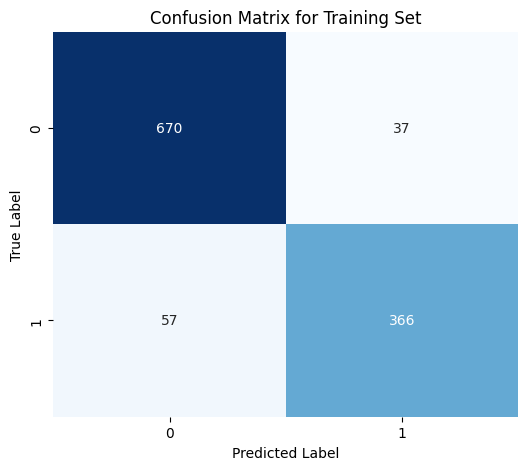

In [ ]:
#I retrain the model with the hyperparameters optimized in the validation set with the library Optuna.
ada_clf = AdaBoostClassifier(estimator=base_est, n_estimators=trial.params["n_estimators"], learning_rate=trial.params["learning_rate"], random_state=42)
#ada_clf.fit(X_train, y_train)
ada_clf.fit(onehot_nat, labels_nat)
# Predictions on the training set
y_train_pred = ada_clf.predict(onehot_nat)

cm = confusion_matrix(labels_nat, y_train_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Training Set')
plt.show()


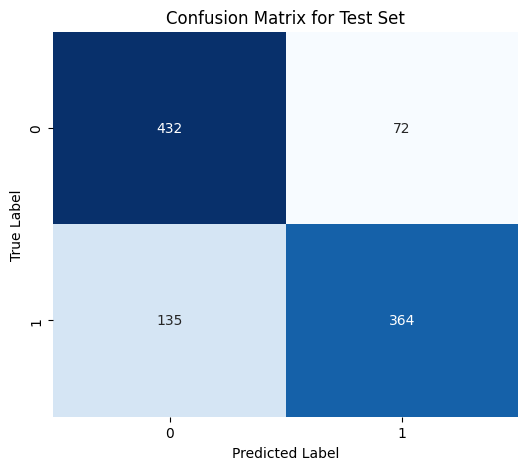

Accuracy on Test Set: 0.7936
F1 Score on Test Set: 0.7786


In [ ]:
# Predict probabilities on the test set and plot the confusion matrix and accuracy on the test set.
y_test_pred = ada_clf.predict(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.show()

print(f"Accuracy on Test Set: {accuracy_test:.4f}")
print(f"F1 Score on Test Set: {f1_test:.4f}")
#Accuracy here is 79%, higher than logistic regression and random forest.

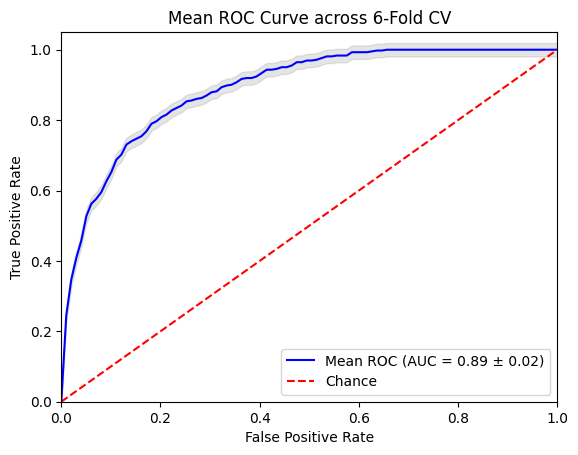

In [ ]:
#Also here, mean ROC curve with 6-fold stratified cross validation.
base_clf = LogisticRegression()
ada_clf = AdaBoostClassifier(estimator=base_est, n_estimators=trial.params["n_estimators"], learning_rate=trial.params["learning_rate"], random_state=42)
cv = StratifiedKFold(n_splits=6, shuffle=True)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
X=onehot_nat
y=labels_nat

for train, test in cv.split(X, y):
    model = ada_clf.fit(X[train], y[train])
    y_score = model.decision_function(X[test])
    fpr, tpr, _ = roc_curve(y[test], y_score)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
plt.figure()
mean_tpr_adab = np.mean(tprs, axis=0)
mean_tpr_adab[-1] = 1.0
mean_auc_adab = auc(mean_fpr, mean_tpr_adab)
std_auc_adab = np.std(aucs)
plt.plot(mean_fpr, mean_tpr_adab, color='b', label=f'Mean ROC (AUC = {mean_auc_adab:.2f} ± {std_auc_adab:.2f})')
plt.fill_between(mean_fpr, mean_tpr_adab - std_auc_adab, mean_tpr_adab + std_auc_adab, color='grey', alpha=0.2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve across 6-Fold CV')
plt.legend(loc="lower right")
plt.show()

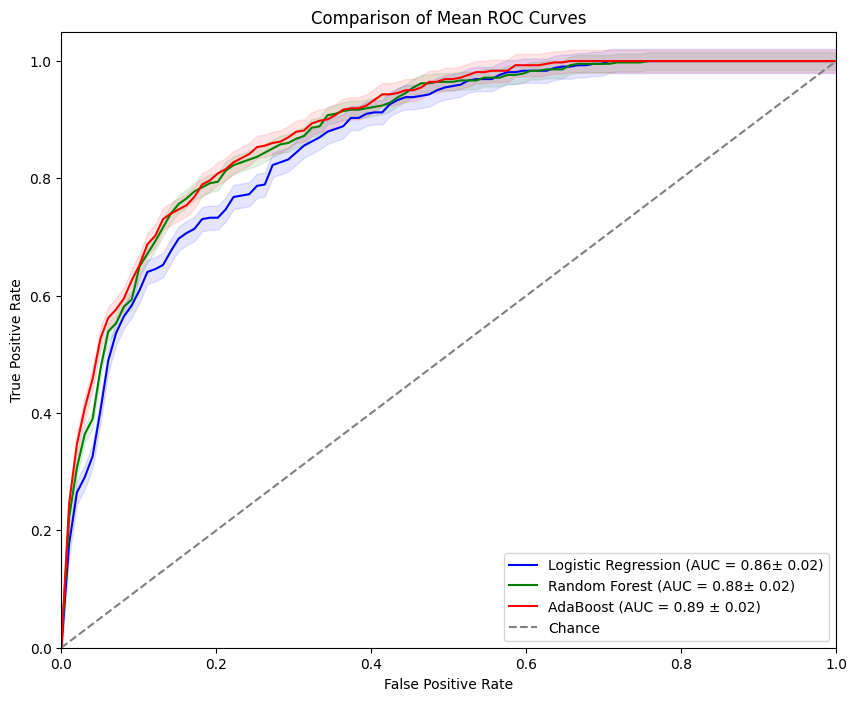

In [ ]:
plt.figure(figsize=(10, 8))

# Assuming mean_fpr, mean_tpr_lr, std_auc_lr, mean_auc_lr are for logistic regression
# And similar variables for random forest and AdaBoost
plt.plot(mean_fpr, mean_tpr_log, color='blue', label=f'Logistic Regression (AUC = {mean_auc_log:.2f}± {std_auc_log:.2f})')
plt.fill_between(mean_fpr, mean_tpr_log - std_auc_log, mean_tpr_log + std_auc_log, color='blue', alpha=0.1)

plt.plot(mean_fpr, mean_tpr_forest, color='green', label=f'Random Forest (AUC = {mean_auc_forest:.2f}± {std_auc_forest:.2f})')
plt.fill_between(mean_fpr, mean_tpr_forest - std_auc_forest, mean_tpr_forest + std_auc_forest, color='green', alpha=0.1)

plt.plot(mean_fpr, mean_tpr_adab, color='red', label=f'AdaBoost (AUC = {mean_auc_adab:.2f} ± {std_auc_adab:.2f})')
plt.fill_between(mean_fpr, mean_tpr_adab - std_auc_adab, mean_tpr_adab + std_auc_adab, color='red', alpha=0.1)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of Mean ROC Curves')
plt.legend(loc="lower right")
plt.show()
#I compare the classifiers I used comparing their AUC. Adaboost performed slightly better than random forest and this two performed better than logistic regression.

# Generative Modeling

Task 5: Generating artifcial sequences
Learn a generative model P(a
1
, ..., a
L
) of your choice from the provided data and generate a set of artifcial amino-acid
sequences by sampling from P. Use your work in Tasks 1-4 to check if your generated sequences are good candidates
for functional sequences or no


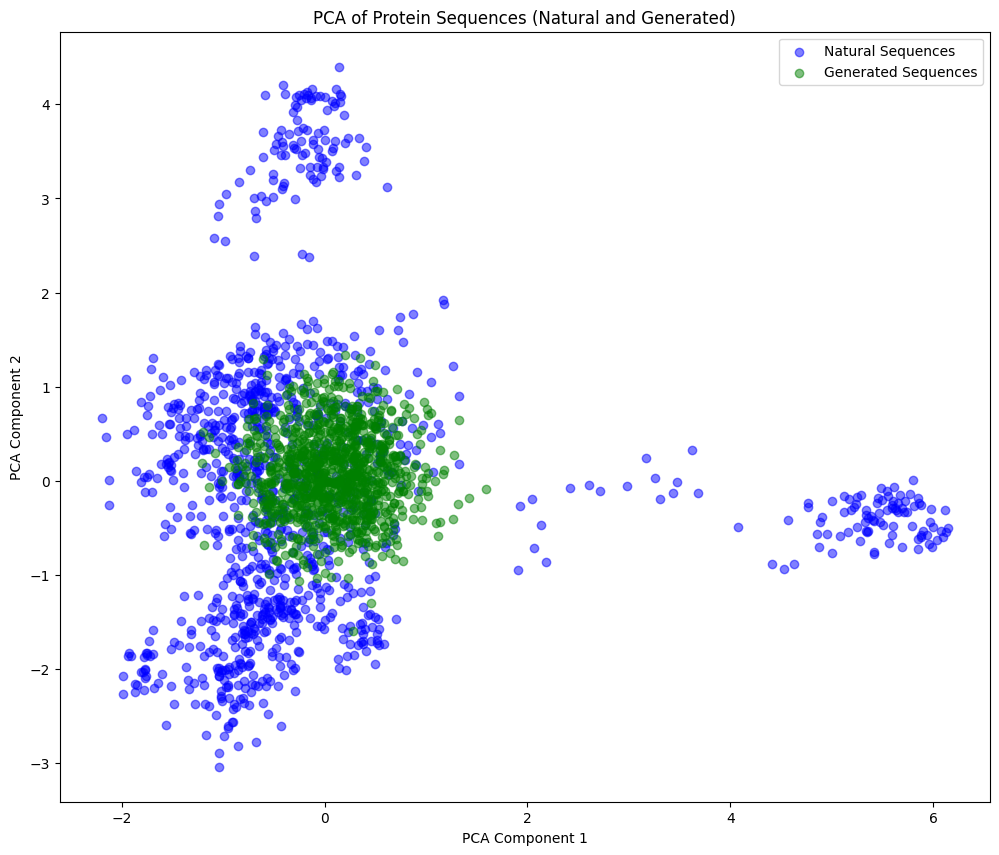

In [ ]:
#I start from an independent fields potts model. This is the simples model you can do for a generative model.
#Here I claim that the 96 sites are all independent and I place in each of them 21 local fields (for each aminoacid and for the alignment gap).
#In the end, I just have to compute the frequencies of each aminoacid in each site, ensure normalization and sample from this distribution.
#In this section I only use natural sequences because I do not want any bias from the pdf of the artificial ones.


amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']

# I create a dictionary to count the frequencies
frequency_data = {aa: np.zeros(96) for aa in amino_acids}

# calculate the single site frequencies for each position of each protein in our natural data
for i in range(96):
    for j, aa in enumerate(amino_acids[:-1]):
        # Sum the column corresponding to this amino acid at this position in order to count each 20 (because of onehot encoding) the number of ones
        frequency_data[aa][i] = np.sum(onehot_nat[:, i * 20 + j])

    # Handle the gap '-' separately as it is represented by a zero vector, so I do not see it if I count the ones.
    frequency_data['-'][i] = len(onehot_nat) - np.sum(np.any(onehot_nat[:, i * 20:(i + 1) * 20], axis=1))

# Convert to probabilities
for aa in amino_acids:
    frequency_data[aa] /= len(onehot_nat)
import random


def sample_protein(frequency_data):
    protein = []
    for i in range(96):
        amino_acids = list(frequency_data.keys())
        probabilities = [frequency_data[aa][i] for aa in amino_acids]
        chosen_aa = random.choices(amino_acids, probabilities)[0]
        protein.append(chosen_aa)
    return ''.join(protein)

# Generate 1000 new proteins from the independent site distribution. This proteins are made by 96 aminoacids (or the alignment gap)
new_proteins = [sample_protein(frequency_data) for _ in range(1000)]

#So I convert them again into onehot encoding sequences
def one_hot_encode(proteins, amino_acids='ACDEFGHIKLMNPQRSTVWY-'):
    encoded = np.zeros((len(proteins), 96 * 20))
    aa_to_index = {aa: i for i, aa in enumerate(amino_acids)}

    for i, protein in enumerate(proteins):
        for j, aa in enumerate(protein):
            if aa in aa_to_index:
                index = j * 20 + aa_to_index[aa]
                if index < 1920:
                    encoded[i, index] = 1
    return encoded

# These are the new one-hot encoded generated proteins
onehot_new_proteins = one_hot_encode(new_proteins)

#Following the previous tasks, we can estimate how the sample generated reflects the true natural sequences.
#As a first visual representation, I project the generated sequences onto the 2 principal components of the natural sequences.
pca = PCA(n_components=2)
pca.fit(onehot_nat)

pca_nat = pca.transform(onehot_nat)
pca_new_proteins = pca.transform(onehot_new_proteins)

plt.figure(figsize=(12, 10))
plt.scatter(pca_nat[:, 0], pca_nat[:, 1], color='blue', alpha=0.5, label='Natural Sequences')
plt.scatter(pca_new_proteins[:, 0], pca_new_proteins[:, 1], color='green', alpha=0.5, label='Generated Sequences')
plt.title('PCA of Protein Sequences (Natural and Generated)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

#We can see that clearly the assumption of independent sites is not enough for capturing the complexity of the model.
#At least, we can see that the generated sequences fall into a region occupied by natural ones.

In [ ]:
#Let's remind the number of functional proteins and their fraction in my original dataset (natural sequences)
functioning_nat, not_functioning_nat, fraction_nat



(423, 707, 37.43362831858407)

In [ ]:
#let's test now the generated sequences with our best classifier found in task 4 (AdaBoost)
#this is done so as to predict the fraction of functional proteins in the generated sequences.
y_test_pred = ada_clf.predict(onehot_new_proteins)
np.sum(y_test_pred)/10
#We find 10.5%, which is wrong compared to the original 37.4%.
#At least, the classifier has understood that the number of functional proteins is less then the non-functional ones.


10.5

In [ ]:
#Now we implement a restricted boltzmann machine, installing all the packages needed.
%pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import convolve
from sklearn import datasets
from sklearn.preprocessing import minmax_scale
from sklearn.neural_network import BernoulliRBM
from sklearn.base import clone

[BernoulliRBM] Iteration 1, pseudo-likelihood = -1274.69, time = 0.23s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -1245.10, time = 0.25s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -1216.07, time = 0.25s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -1187.27, time = 0.25s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -1158.76, time = 0.22s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -1130.90, time = 0.22s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -1104.04, time = 0.25s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -1078.19, time = 0.34s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -1053.96, time = 0.38s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -1031.18, time = 0.37s


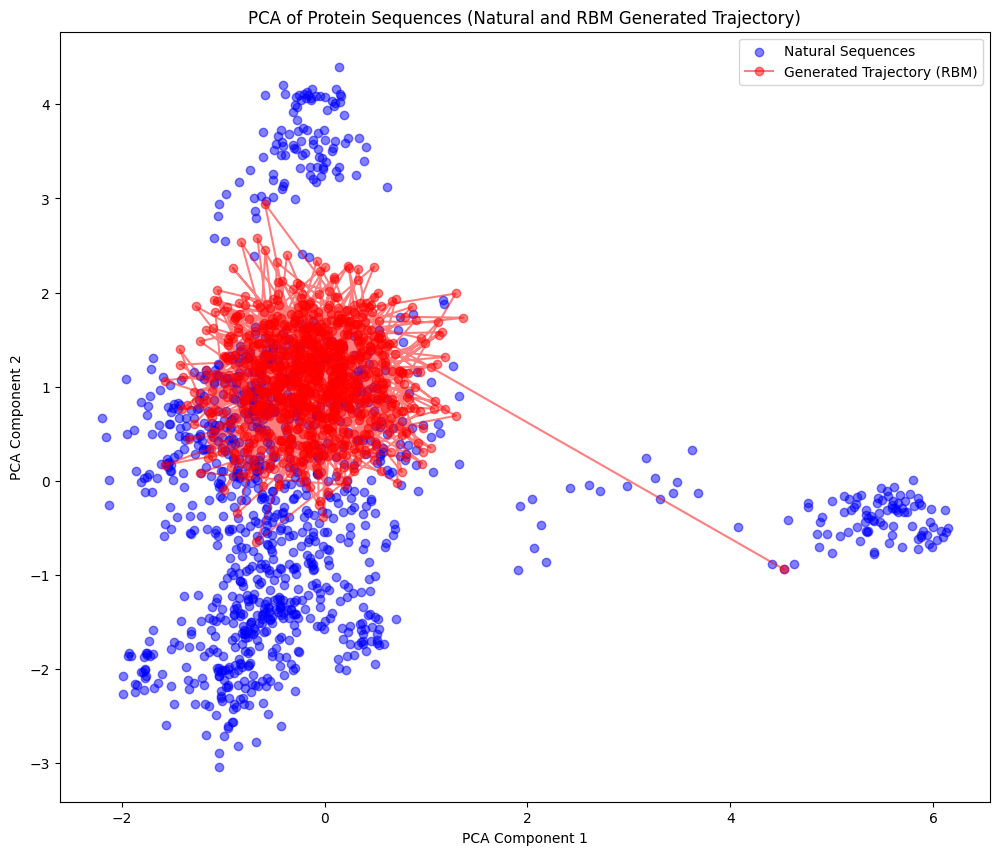

In [ ]:
#I create the restricted boltzmann machine.
#rbm = BernoulliRBM(n_components=100, learning_rate=0.01, batch_size=500, n_iter=20, random_state=42)
logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1)
rbm = BernoulliRBM(random_state=0, batch_size=500, verbose=True)
rbm_features_classifier = Pipeline(steps=[("rbm", rbm), ("logistic", logistic)])
#rbm.learning_rate = 0.001
#rbm.n_iter = 10

#we use this parameters that give the "best" visual representation in the pca space. This is reasonable, since with only 10 iterations we are not giving the time to the pseudolikelihood to decrease significantly
rbm.learning_rate = 0.01
rbm.n_iter = 10
rbm.n_components = 20

rbm_features_classifier.fit(onehot_nat, labels_nat)

#here I construct a vector and fill it with the 1000 sequences sampled by gibbs(v)
#In this way, I use Gibbs sampling to sample a whole trajectory of lenght 1000 and I stor all the datapoints (that is, indeed, my generated sequence)
#Note that I start from a random natural sequence, and I sample from that one
initial_sequence = onehot_nat[np.random.randint(len(onehot_nat))]
sample_gibbs=[initial_sequence]
for i in range(1000):
    sample_gibbs.append(rbm.gibbs(sample_gibbs[-1]))    #sample_gibbs.append(v)

sample_gibbs=np.array(sample_gibbs) #this is my sample and this is already in one-hot encoding

pca = PCA(n_components=2)
pca.fit(onehot_nat)

pca_nat = pca.transform(onehot_nat)
pca_sample_gibbs = pca.transform(sample_gibbs)

plt.figure(figsize=(12, 10))
plt.scatter(pca_nat[:, 0], pca_nat[:, 1], color='blue', alpha=0.5, label='Natural Sequences')
plt.plot(pca_sample_gibbs[:, 0],pca_sample_gibbs[:,1], color='red', alpha=0.5, label='Generated Trajectory (RBM)', marker='o')
plt.title('PCA of Protein Sequences (Natural and RBM Generated Trajectory)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


In [ ]:
#The generated sample looks better than the independent sites one. Still, it is not satisfactory.
sample_gibbs.shape

(1001, 1920)

In [ ]:
rbm_pred = ada_clf.predict(sample_gibbs)
np.sum(rbm_pred)/1001
#the fraction of functional proteins here is predicted to be the 20%, better than the independent site model but not enough yet.

0.2

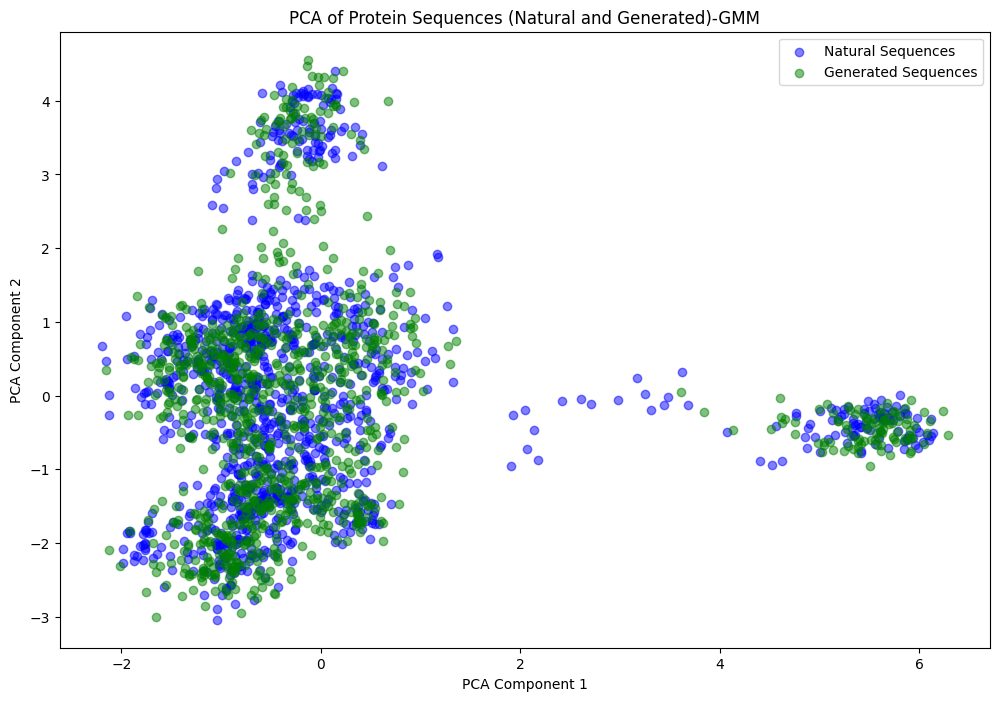

In [ ]:
#Here I employ a gaussian mixture model to generate, hopefully, better sequences.
#The "trick" I employ is to modify the onehot_encoded sequences. In particular, I extend each aminoacid (made of 19 zeros and 1 one) with a final 0 (total lenght of 21).
#Moreover, I add a final 1 to the alignment gap, which is no more a 20 zero components vector.
#This is done to allow the alignment gap to be actually sampled (otherwise, a 0 vector would not be sampled).
#In this way, I apply a GMM generative model and sample new proteins taking the maximum of each aminoacid (the 21 component vector).
#In this way, if the maximum is the last component (the 21st component added) it means that I am adding an alignment gap!
#In the end, I remove this 21th component to all the aminoacids sampled sequences for amino acid !='-' or otherwise I add a '-'.

def transform_sequences(onehot_sequences):
    transformed = np.zeros((onehot_sequences.shape[0], 96 * 21))  # 96 positions, now 21 elements each (I enlarg the onehot encoded vectors)

    for i, sequence in enumerate(onehot_sequences):
        for j in range(96):
            amino_acid_vector = sequence[j * 20:(j + 1) * 20]
            if np.sum(amino_acid_vector) == 0:  # If it's a gap ('-'), append a 1 at the end of the 20 zeros.
                new_vector = np.append(amino_acid_vector, 1)
            else:  # For all other amino acids append a 0.
                new_vector = np.append(amino_acid_vector, 0)
            transformed[i, j * 21:(j + 1) * 21] = new_vector

    return transformed

# Enlarge the sequences (the modified ones)
transformed_onehot_nat = transform_sequences(onehot_nat)

#I use 10 components for the GMM
gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=20)
gmm.fit(transformed_onehot_nat)

# Sample new data from the GMM
new_samples = gmm.sample(1000)[0]  # [0] because I get the samples and not the labels

#function for reshaping the samples in the original onehot encoding
def transform_to_original_onehot(samples, amino_acid_length=20):
    num_proteins, total_length = samples.shape
    num_amino_acids = total_length // (amino_acid_length + 1)  #the +1 because I include the gap
    transformed_samples = np.zeros((num_proteins, num_amino_acids * amino_acid_length))

    for i, protein in enumerate(samples):
        for j in range(num_amino_acids):
            chunk = protein[j * (amino_acid_length + 1):(j + 1) * (amino_acid_length + 1)]
            max_index = np.argmax(chunk)

            # If max_index is the last position, it's an alignment gap, otherwise it's an amino acid
            if max_index < amino_acid_length:
                transformed_samples[i, j * amino_acid_length + max_index] = 1

    return transformed_samples

# Transform the new samples of 100 artificial proteins to the original one-hot encoding
final_generated_samples = transform_to_original_onehot(new_samples)

pca = PCA(n_components=2)
pca.fit(onehot_nat)

pca_nat = pca.transform(onehot_nat)
pca_generated = pca.transform(final_generated_samples)
plt.figure(figsize=(12, 8))
plt.scatter(pca_nat[:, 0], pca_nat[:, 1], color='blue', alpha=0.5, label='Natural Sequences')
plt.scatter(pca_generated[:, 0], pca_generated[:, 1], color='green', alpha=0.5, label='Generated Sequences')
plt.title('PCA of Protein Sequences (Natural and Generated)-GMM')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()



In [ ]:
final_generated_samples.shape


(1000, 1920)

In [ ]:
GMM_pred = ada_clf.predict(final_generated_samples)
np.sum(GMM_pred)/10
#Much better! 42.6% of the generated sample is predicted to be functional against the real 37% of the original natural sequences.

42.6

In [ ]:
#Lastly, I tried to implement an N-gram model, which are used in NLP and are very basic models.
#In the end what they just do is using the chain rule and Markow assumption.

#What I thought is that MSA natural sequences, in our case, could be viewed as a sequence of 21 possible words/token, i.e. amino acids and alignment gap.
#In this sense, we can evaluate the probability of having a letter given by a preceeding context in a sentence. In our case, we could evaluate the probability of having a certain aminoacid given a preceeding sequence of amino acids.
#Here I try to implement a 3-gram model, i.e. from my natural sequences I evaluate the occurrencies of having couples of aminoacids (couple of words) and compute the probability of having an aminoacid giving the preceeding two.
#I then sample from this distribution and try to see if they correctly reproduce the natural sequences.

#The results are quite delusional, but most importantly I found it stimulating!


# Here I go back to the original sequences from onehot encoding, because I want the aminoacids.
def onehot_to_sequences(onehot_encoded, sequence_length=96):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
    sequences = []
    for protein in onehot_encoded:
        sequence = ''
        for i in range(sequence_length):
            onehot_aa = protein[i*20:(i+1)*20]
            if np.sum(onehot_aa) == 0:  # Check if the vector of 20 components is all zeros for a gap
                sequence += '-'
            else:
                aa_index = np.argmax(onehot_aa)  # Use np.argmax to find the index of the 1 to understand which letter it is.
                sequence += amino_acids[aa_index]
        sequences.append(sequence)
    return sequences

#In the 3-Gram Model, I initialise a dictionary and count the 3-grams but I also have to initialize the starting 3-grams.
def build_3gram_model(sequences):
    tri_counts = defaultdict(int)
    start_counts = defaultdict(int)

    for seq in sequences:
        start_counts[seq[:3]] += 1
        for i in range(len(seq)-2):
            tri_counts[seq[i:i+3]] += 1

    #Here I convert the counts of the occurrancies of the 3-grams into probabilities
    total_starts = sum(start_counts.values())
    start_probs = {k: v / total_starts for k, v in start_counts.items()}

    tri_probs = {}
    for tri, count in tri_counts.items():
        prefix = tri[:2]
        prefix_count = sum(count for trigram, count in tri_counts.items() if trigram.startswith(prefix))
        tri_probs[tri] = count / prefix_count

    return start_probs, tri_probs


def sample_sequence(start_probs, tri_probs, length=96):
    # Start the sequence with a random 3-gram because I need a starting point.
    start = random.choices(list(start_probs.keys()), weights=start_probs.values())[0]
    sequence = start

    while len(sequence) < length:
        prefix = sequence[-2:]
        # Filter tri_probs for the current prefix
        filtered_probs = {k: v for k, v in tri_probs.items() if k.startswith(prefix)}
        if filtered_probs:
            next_aa = random.choices(list(filtered_probs.keys()), weights=filtered_probs.values())[0][2]
            sequence += next_aa
        else:
            break

    return sequence

# Convert the onehot_nat back to sequences
sequences = onehot_to_sequences(onehot_nat)

# Build the 3-gram model
start_probs, tri_probs = build_3gram_model(sequences)

# Sample 1000 new sequences
generated_sequences = [sample_sequence(start_probs, tri_probs) for _ in range(1000)]


In [ ]:
len(generated_sequences)

1000

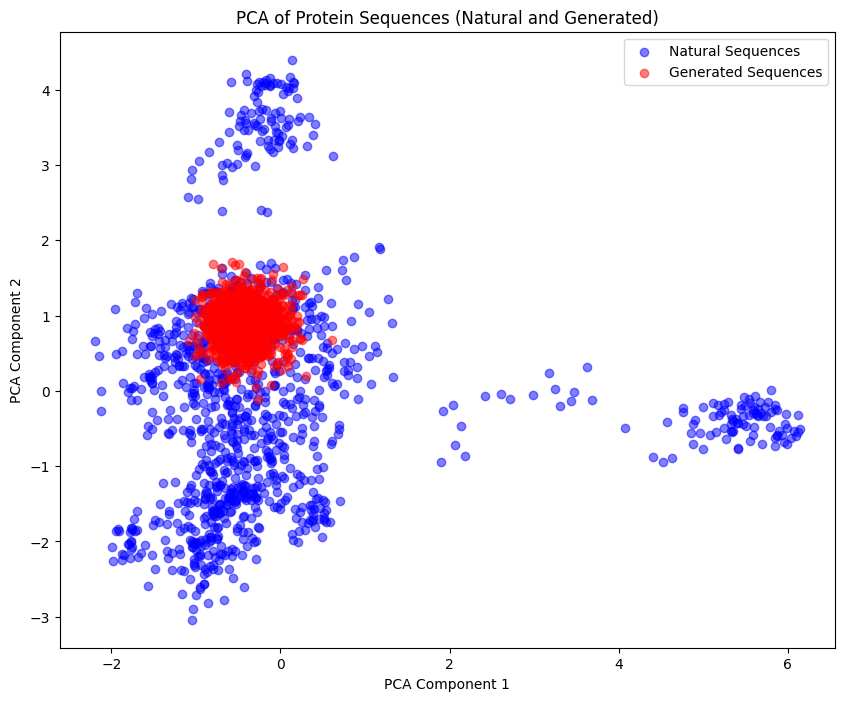

In [ ]:
def sequence_to_onehot(sequences):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_to_onehot = {aa: [1 if aa == a else 0 for a in amino_acids] for aa in amino_acids}
    aa_to_onehot['-'] = [0] * 20
    onehot_encoded = []

    for seq in sequences:
        onehot_seq = []
        for aa in seq:
            onehot_seq.extend(aa_to_onehot.get(aa, [0] * 20))
        onehot_encoded.append(onehot_seq)
    return np.array(onehot_encoded)
generated_sequences_onehot = sequence_to_onehot(generated_sequences)



pca = PCA(n_components=2)
pca.fit(onehot_nat)
pca_nat = pca.transform(onehot_nat)
pca_generated = pca.transform(generated_sequences_onehot)

plt.figure(figsize=(10, 8))
plt.scatter(pca_nat[:, 0], pca_nat[:, 1], color='blue', alpha=0.5, label='Natural Sequences')
plt.scatter(pca_generated[:, 0], pca_generated[:, 1], color='red', alpha=0.5, label='Generated Sequences')
plt.title('PCA of Protein Sequences (Natural and Generated)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()
#unfortunately, the results are not satisfying. I was thinking that maybe this could be caused by redundancies of words (the dictionary is small), or by the choice of 3-grams or by too limited data.